In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


In [9]:
plt.rcParams.update({'font.size': 12})

In [69]:
df = pd.read_csv('../data/day_approach_maskedID_timeseries.csv')
df.head()

nr. sessions  total km  km Z3-4  km Z5-T1-T2  km sprinting  \
0           1.0       5.8      0.0          0.6           1.2   
1           0.0       0.0      0.0          0.0           0.0   
2           1.0       0.0      0.0          0.0           0.0   
3           0.0       0.0      0.0          0.0           0.0   
4           1.0       0.0      0.0          0.0           0.0   

   strength training  hours alternative  perceived exertion  \
0                0.0               0.00                0.11   
1                0.0               0.00               -0.01   
2                1.0               0.00                0.10   
3                0.0               0.00               -0.01   
4                0.0               1.08                0.08   

   perceived trainingSuccess  perceived recovery  ...  km Z5-T1-T2.6  \
0                       0.00                0.18  ...            0.0   
1                      -0.01               -0.01  ...            0.5   
2                       0.00                0.17  ...            0.0   
3                      -0.01               -0.01  ...            0.0   
4                       0.00                0.18  ...            0.0   

   km sprinting.6  strength training.6  hours alternative.6  \
0             0.0                  0.0                  1.0   
1             1.2                  0.0                  0.0   
2             0.0                  0.0                  0.0   
3             0.0                  1.0                  0.0   
4             0.0                  0.0                  0.0   

   perceived exertion.6  perceived trainingSuccess.6  perceived recovery.6  \
0                  0.10                         0.00                  0.15   
1                  0.10                         0.00                  0.17   
2                 -0.01                        -0.01                 -0.01   
3                  0.10                         0.00                  0.17   
4                  0.11                         0.00                  0.17   

   Athlete ID  injury  Date  
0           0       0     0  
1           0       0     1  
2           0       0     2  
3           0       0     3  
4           0       0     4  

[5 rows x 73 columns]

## EDA: ##

In [7]:
df.shape

(42766, 73)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 73 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   nr. sessions                 42766 non-null  float64
 1   total km                     42766 non-null  float64
 2   km Z3-4                      42766 non-null  float64
 3   km Z5-T1-T2                  42766 non-null  float64
 4   km sprinting                 42766 non-null  float64
 5   strength training            42766 non-null  float64
 6   hours alternative            42766 non-null  float64
 7   perceived exertion           42766 non-null  float64
 8   perceived trainingSuccess    42766 non-null  float64
 9   perceived recovery           42766 non-null  float64
 10  nr. sessions.1               42766 non-null  float64
 11  total km.1                   42766 non-null  float64
 12  km Z3-4.1                    42766 non-null  float64
 13  km Z5-T1-T2.1   

In [8]:
df.columns

Index(['nr. sessions', 'total km', 'km Z3-4', 'km Z5-T1-T2', 'km sprinting',
       'strength training', 'hours alternative', 'perceived exertion',
       'perceived trainingSuccess', 'perceived recovery', 'nr. sessions.1',
       'total km.1', 'km Z3-4.1', 'km Z5-T1-T2.1', 'km sprinting.1',
       'strength training.1', 'hours alternative.1', 'perceived exertion.1',
       'perceived trainingSuccess.1', 'perceived recovery.1', 'nr. sessions.2',
       'total km.2', 'km Z3-4.2', 'km Z5-T1-T2.2', 'km sprinting.2',
       'strength training.2', 'hours alternative.2', 'perceived exertion.2',
       'perceived trainingSuccess.2', 'perceived recovery.2', 'nr. sessions.3',
       'total km.3', 'km Z3-4.3', 'km Z5-T1-T2.3', 'km sprinting.3',
       'strength training.3', 'hours alternative.3', 'perceived exertion.3',
       'perceived trainingSuccess.3', 'perceived recovery.3', 'nr. sessions.4',
       'total km.4', 'km Z3-4.4', 'km Z5-T1-T2.4', 'km sprinting.4',
       'strength training.4',

In [14]:
df['Date'].describe()

count    42766.000000
mean      1228.039892
std        807.021168
min          0.000000
25%        436.000000
50%       1256.000000
75%       1913.000000
max       2673.000000
Name: Date, dtype: float64

### Explore target variable ###

In [13]:
# explore target variable
df['injury'].value_counts(normalize=True)

0    0.986368
1    0.013632
Name: injury, dtype: float64

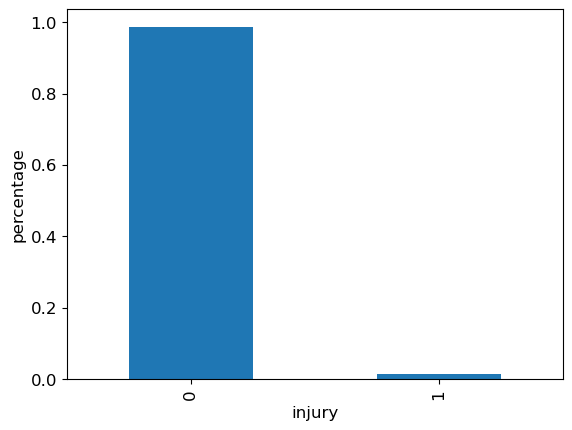

In [67]:
pd.value_counts(df['injury'],normalize=True).plot.bar()
plt.xlabel('injury')
plt.ylabel('percentage')
plt.savefig('../figures/injury.png')
plt.show()

### Explore differences between athletes ###

In [7]:
df['Athlete ID'].value_counts()

32    1791
20    1723
22    1478
43    1471
41    1393
      ... 
11     154
39     130
15     126
55      48
60      43
Name: Athlete ID, Length: 74, dtype: int64

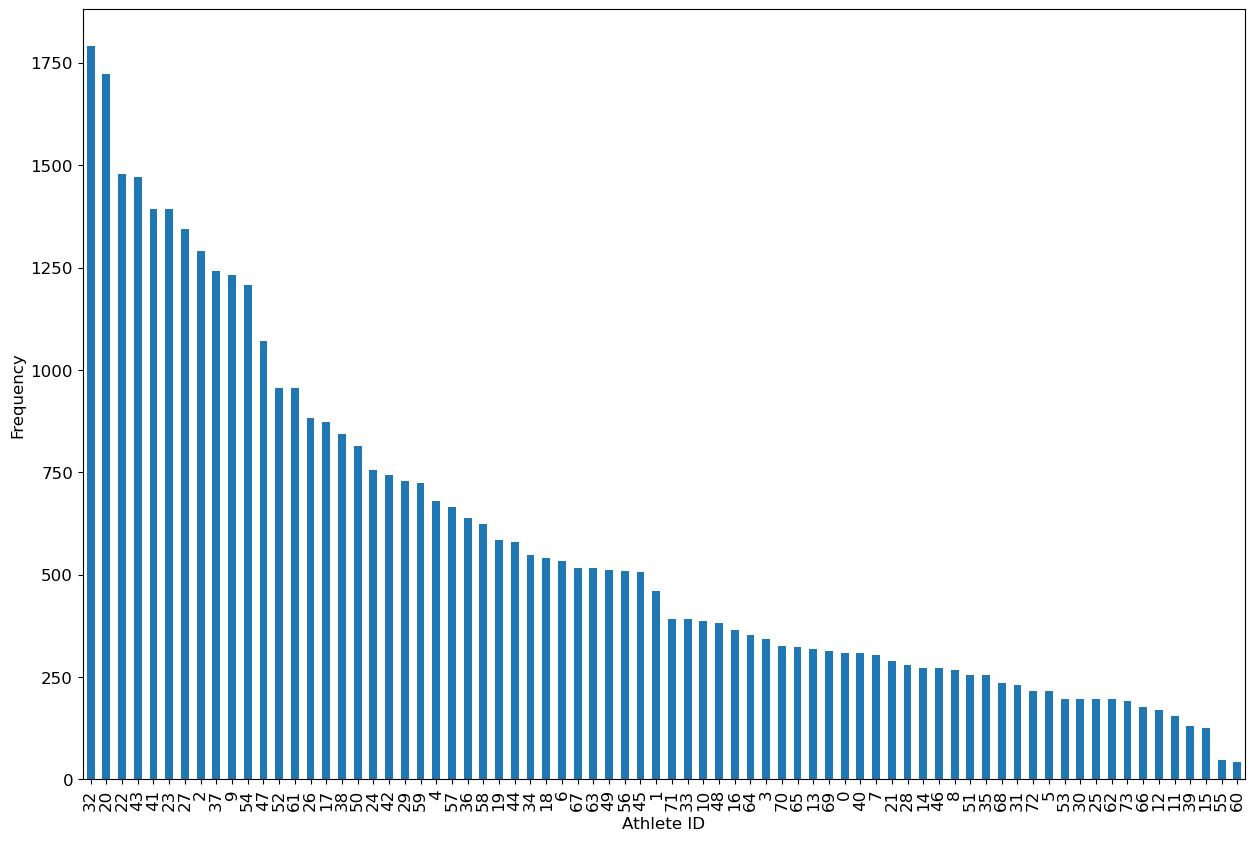

In [18]:
pd.value_counts(df['Athlete ID']).plot.bar(figsize = (15,10))
plt.xlabel('Athlete ID')
plt.ylabel('Frequency')
plt.savefig('../figures/athlete_frequency.png')
plt.show()

In [19]:
# how likely does each athlete get injured?
perc_injured_per_athlete = df.groupby(['Athlete ID']).agg({'injury':'sum','Date':'count'}).reset_index()
perc_injured_per_athlete['perc_injury'] = perc_injured_per_athlete['injury'] / df.groupby(['Athlete ID']).agg({'injury':'count'})['injury']
perc_injured_per_athlete = perc_injured_per_athlete.sort_values(by = ['perc_injury'])
perc_injured_per_athlete

Athlete ID  injury  Date  perc_injury
73          73       0   192     0.000000
62          62       0   196     0.000000
46          46       0   272     0.000000
72          72       0   216     0.000000
31          31       0   231     0.000000
..         ...     ...   ...          ...
68          68       8   235     0.034043
36          36      22   638     0.034483
26          26      35   884     0.039593
42          42      32   744     0.043011
29          29      33   730     0.045205

[74 rows x 4 columns]

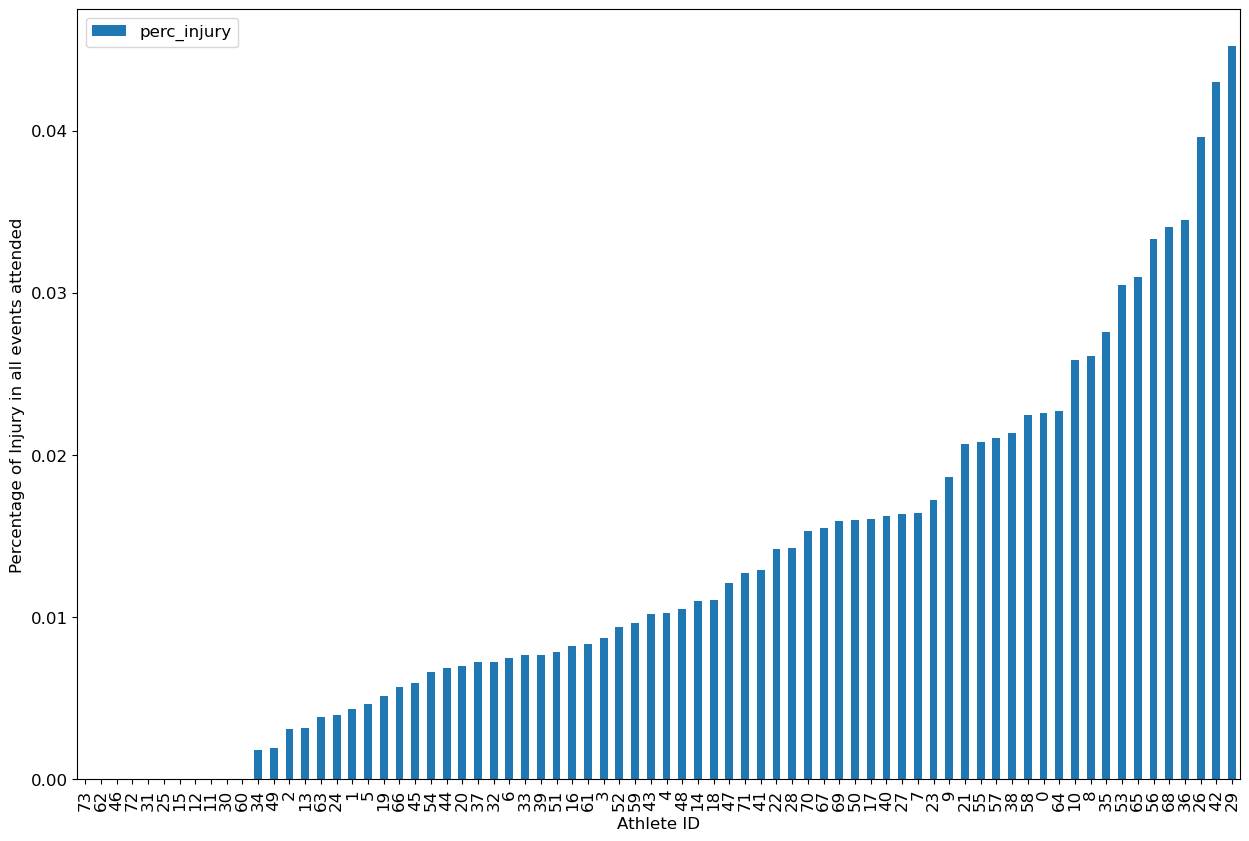

In [20]:
perc_injured_per_athlete.plot.bar('Athlete ID','perc_injury', figsize = (15,10))
plt.xlabel('Athlete ID')
plt.ylabel('Percentage of Injury in all events attended')
plt.savefig('../figures/athlete_injury.png')
plt.show()

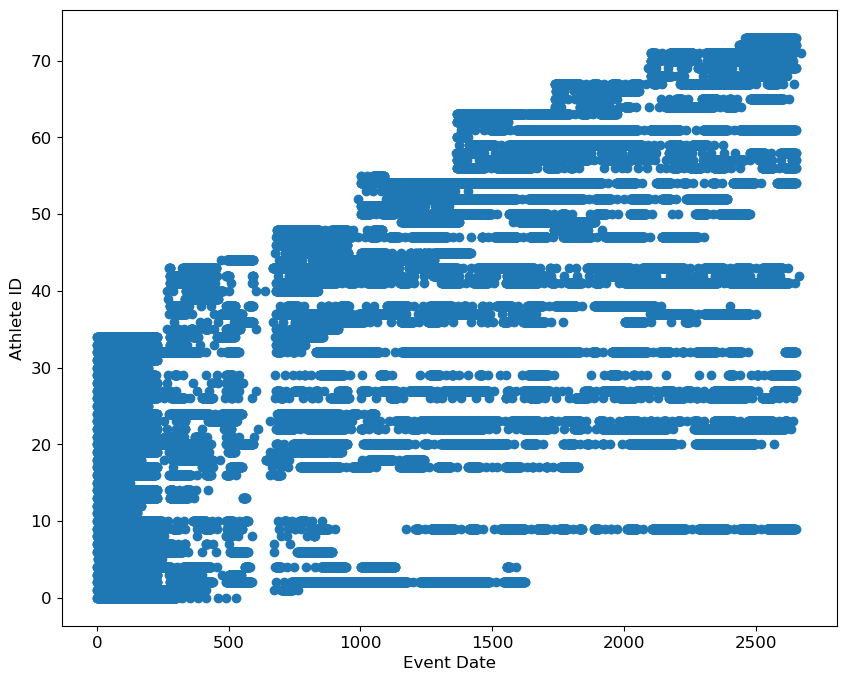

In [22]:
# plot which athletes compete in which competitions: 
# athletes enter in batches
plt.figure(figsize=(10,8))
plt.scatter(df['Date'], df['Athlete ID'])
plt.xlabel('Event Date')
plt.ylabel('Athlete ID')
plt.savefig('../figures/athlete_date.png')
plt.show()

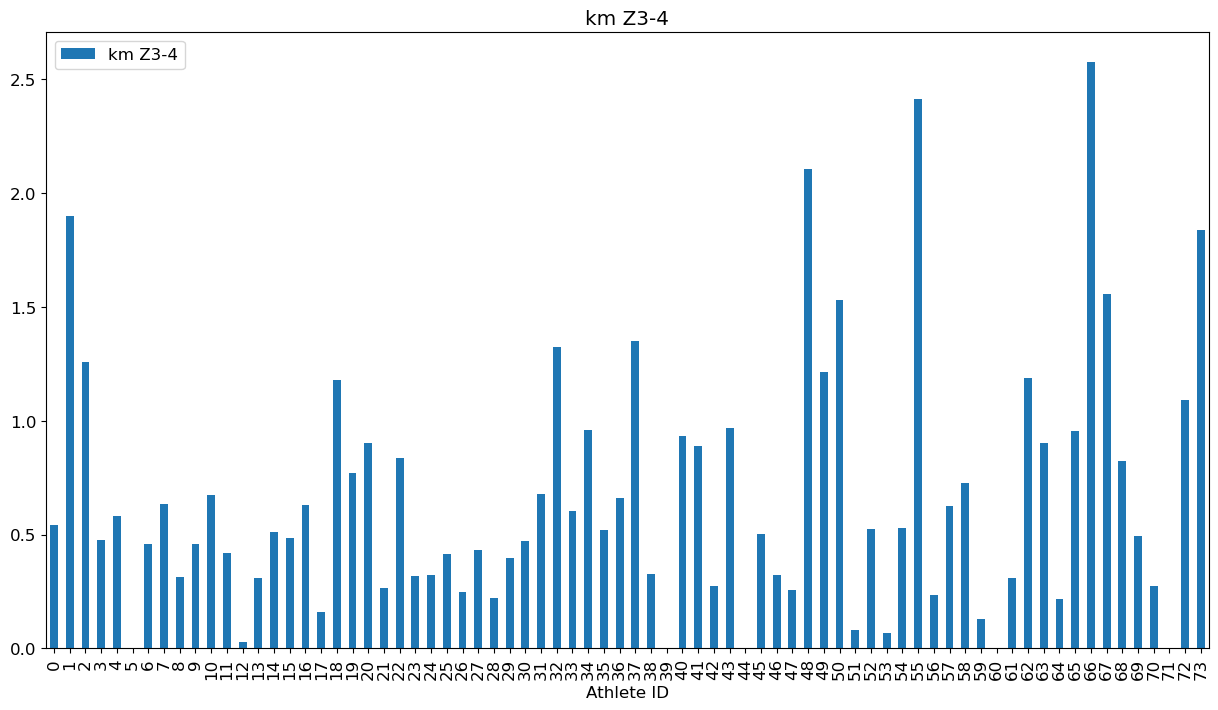

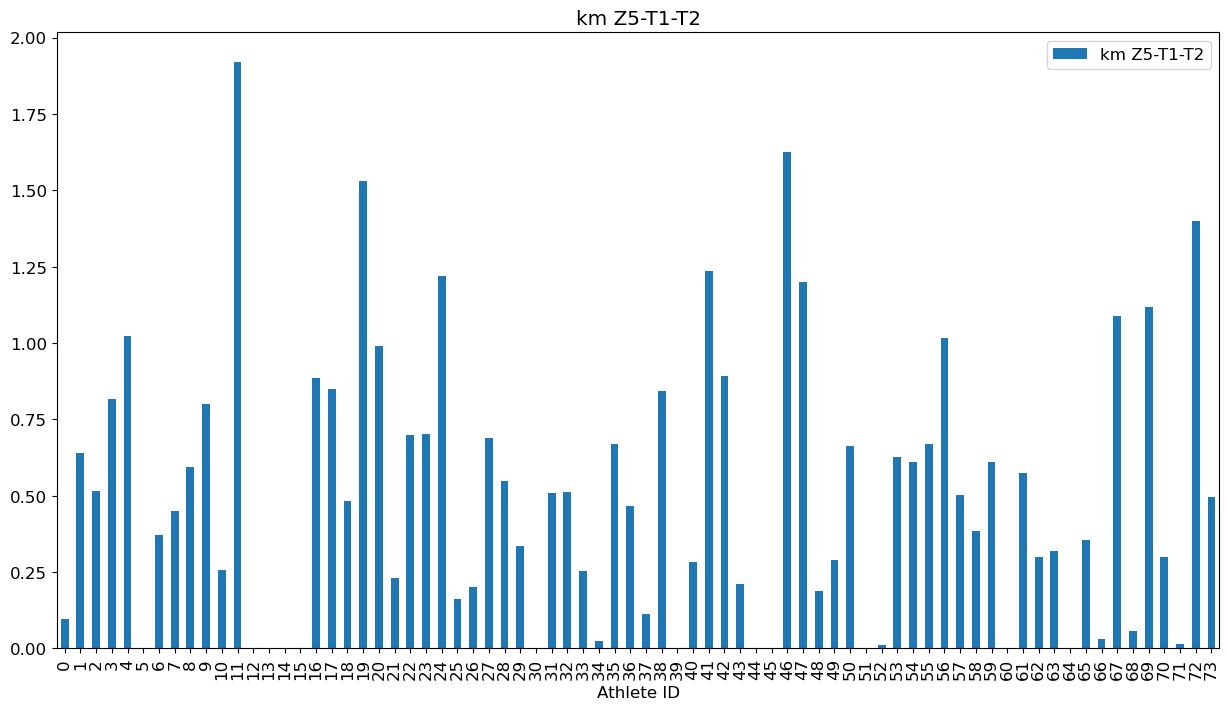

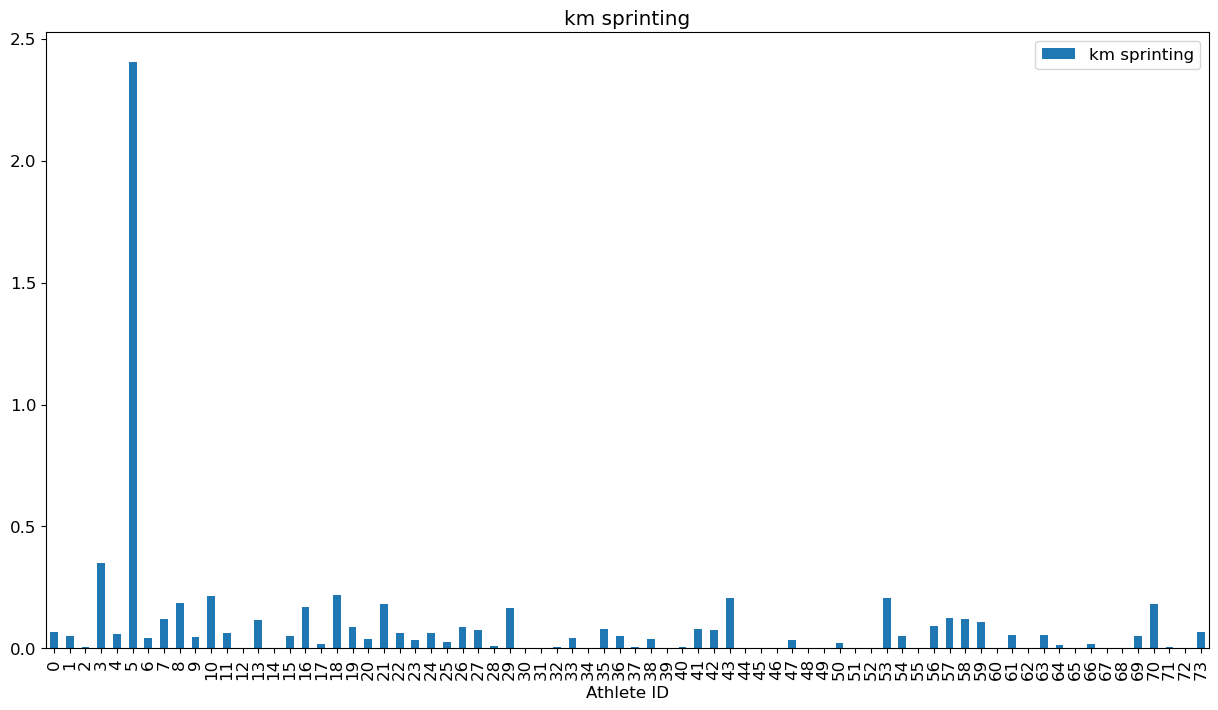

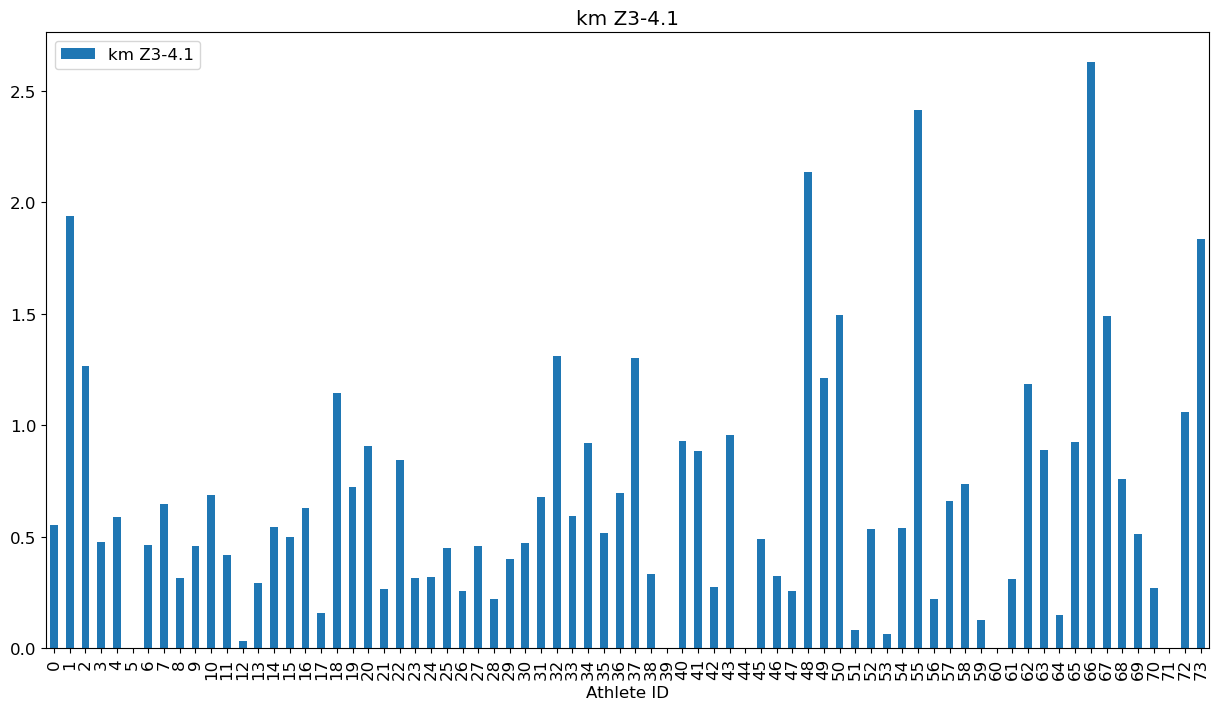

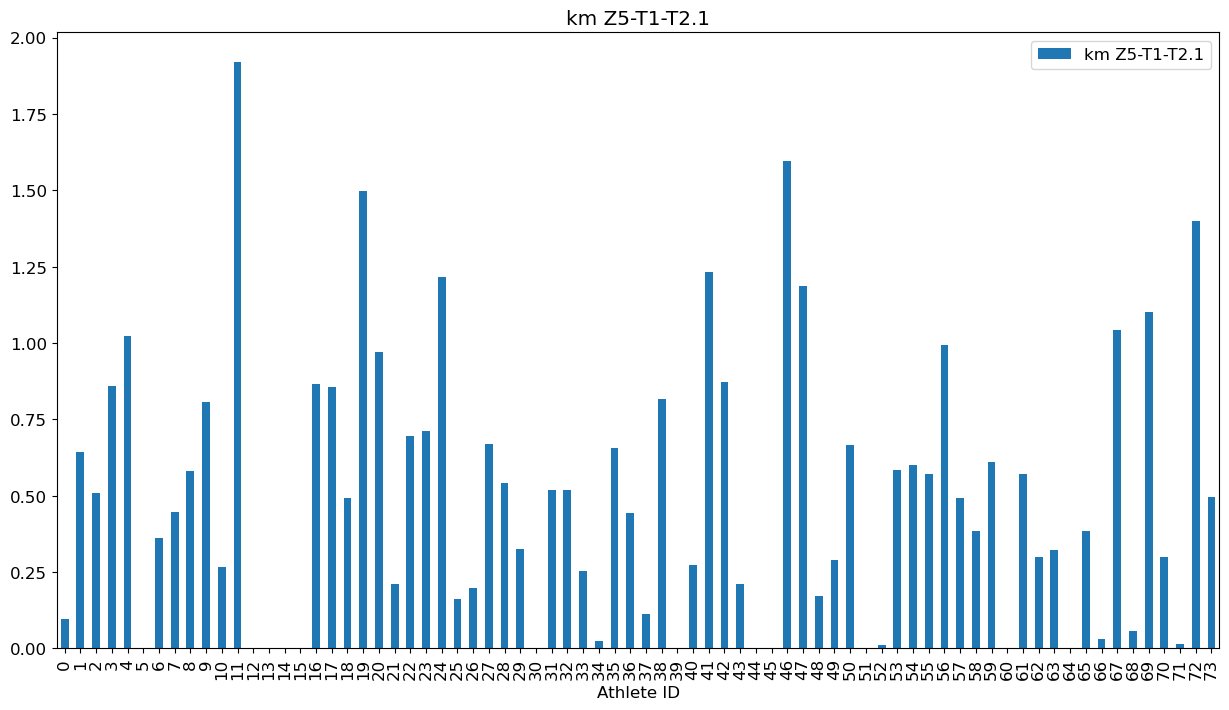

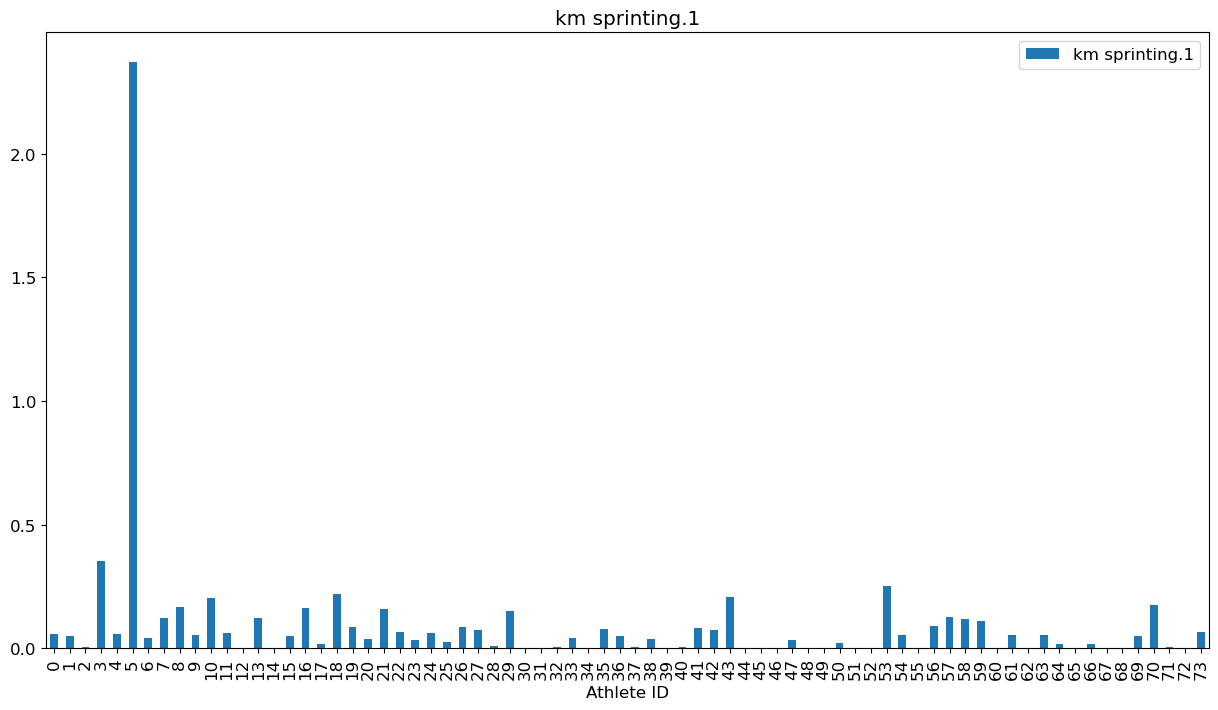

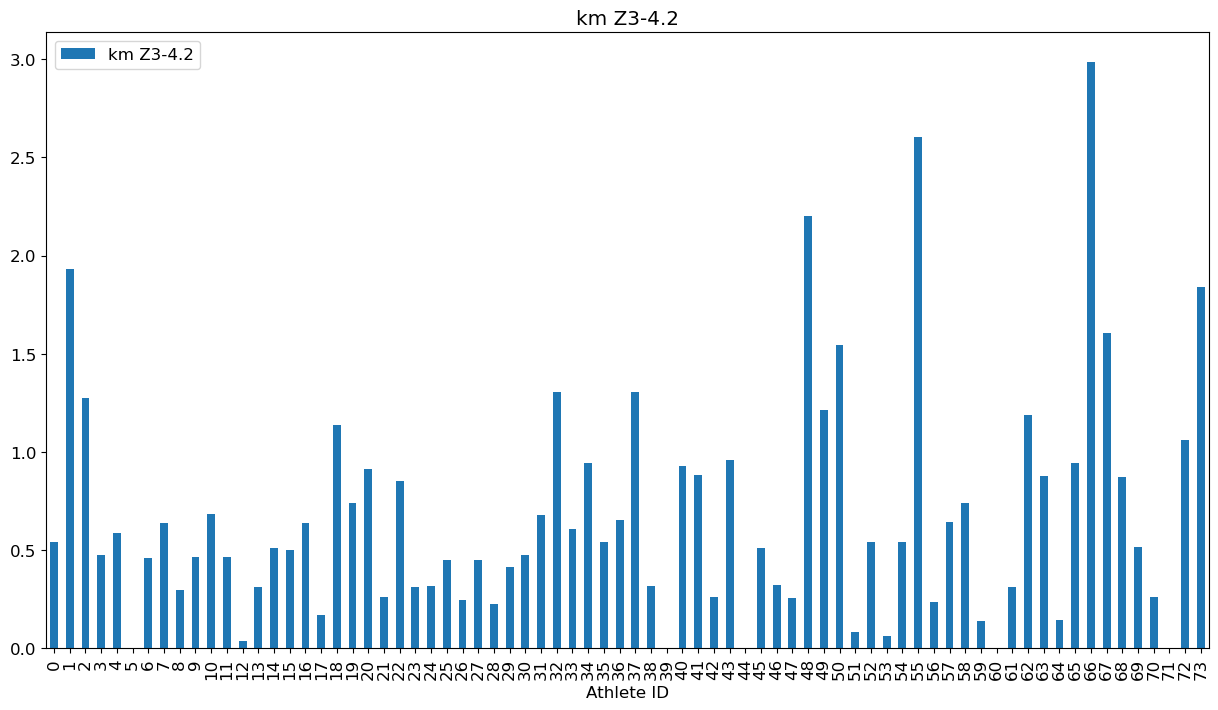

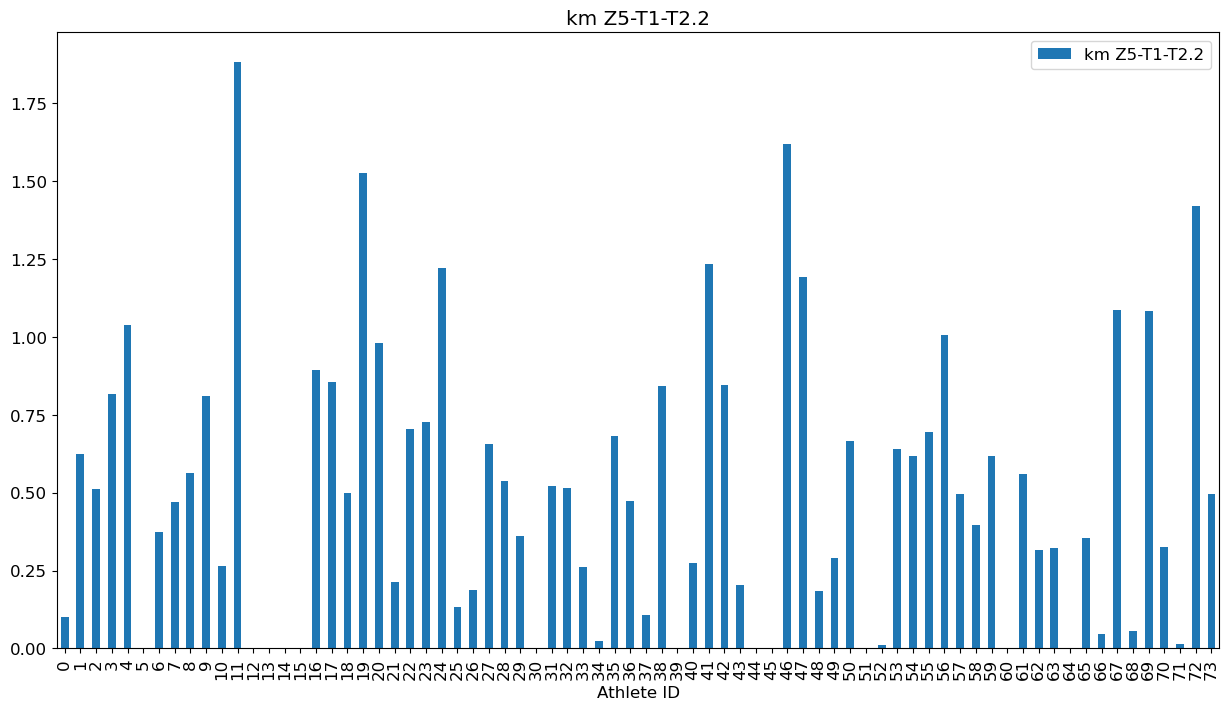

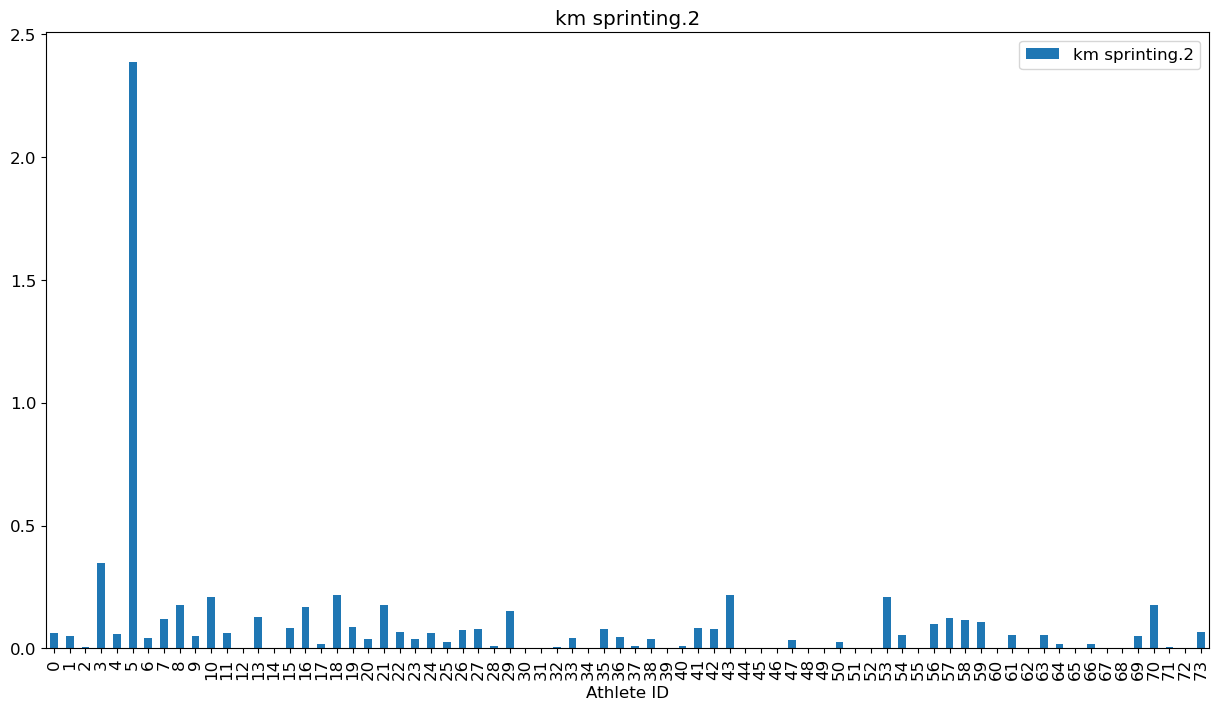

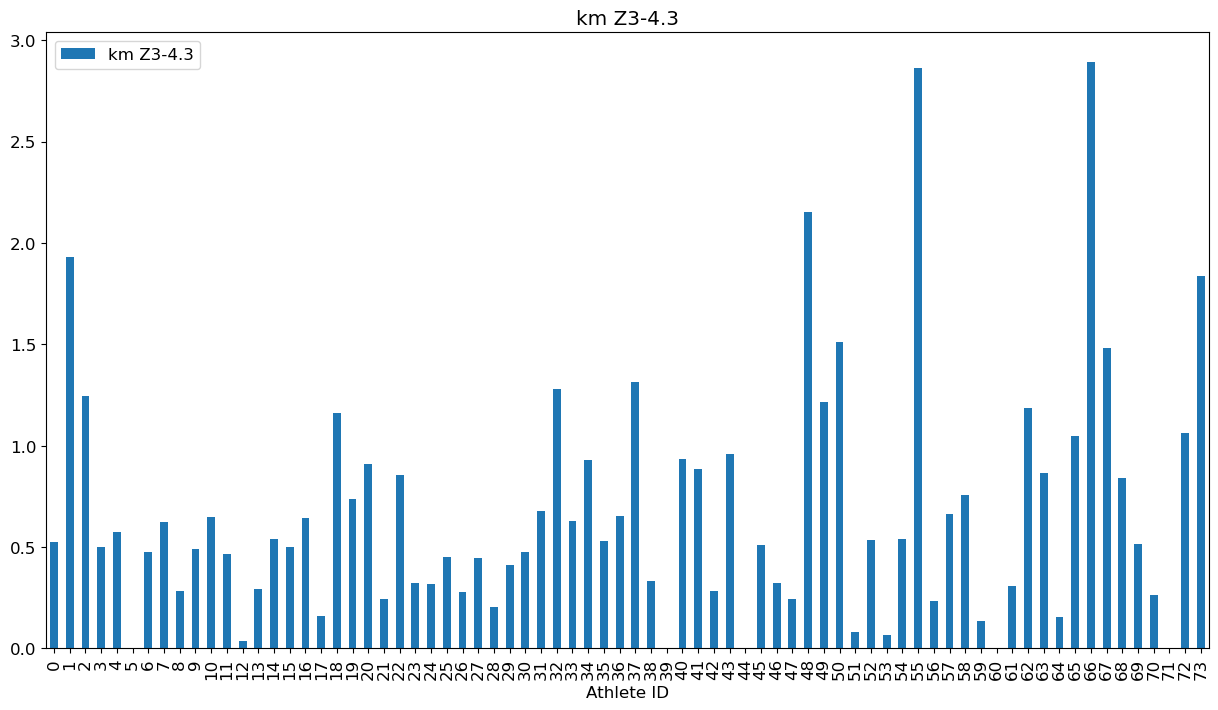

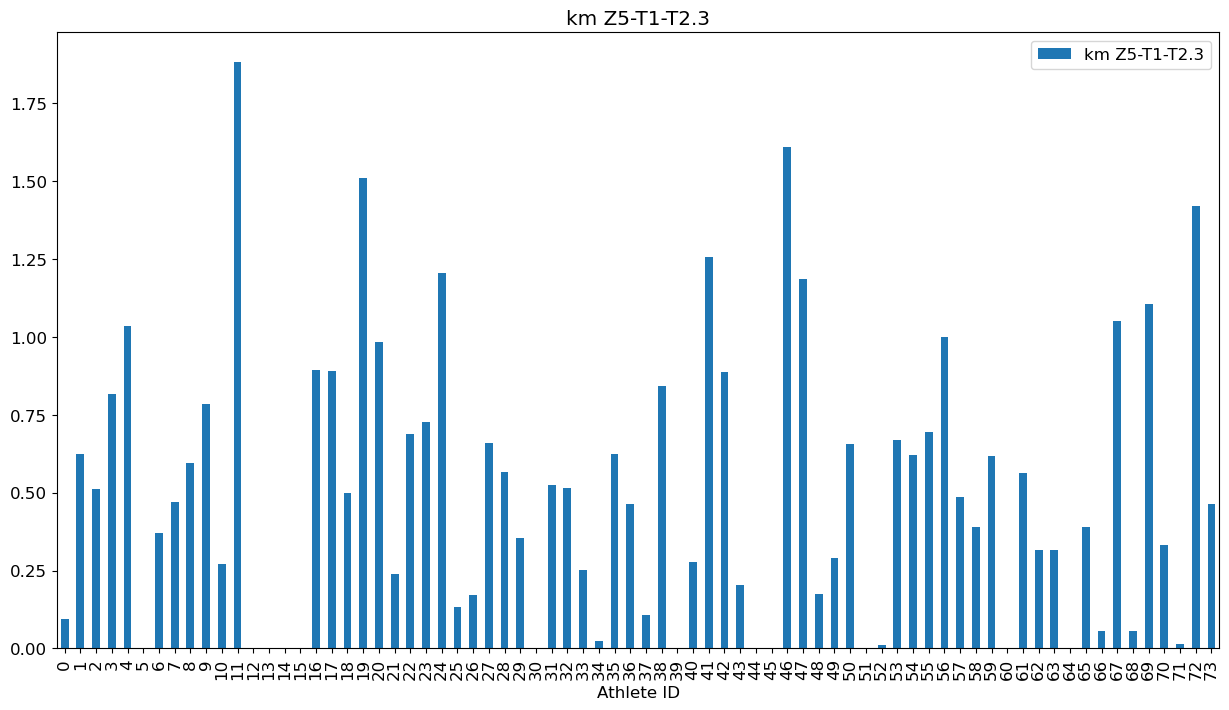

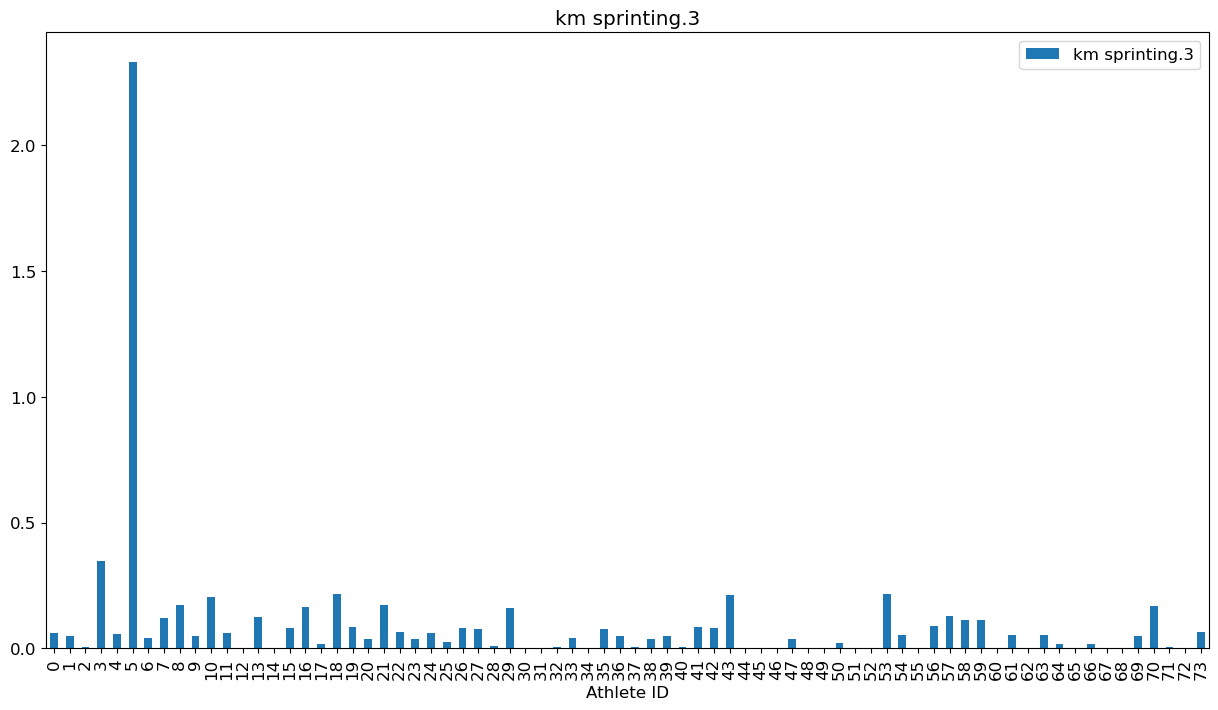

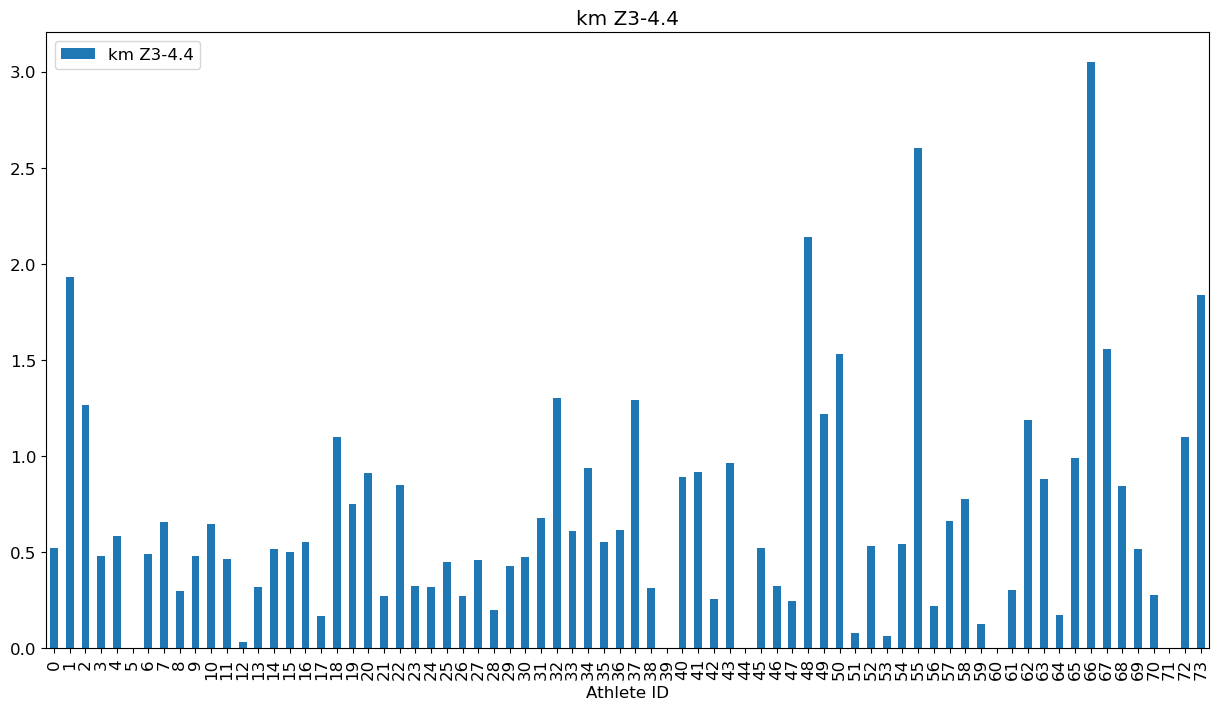

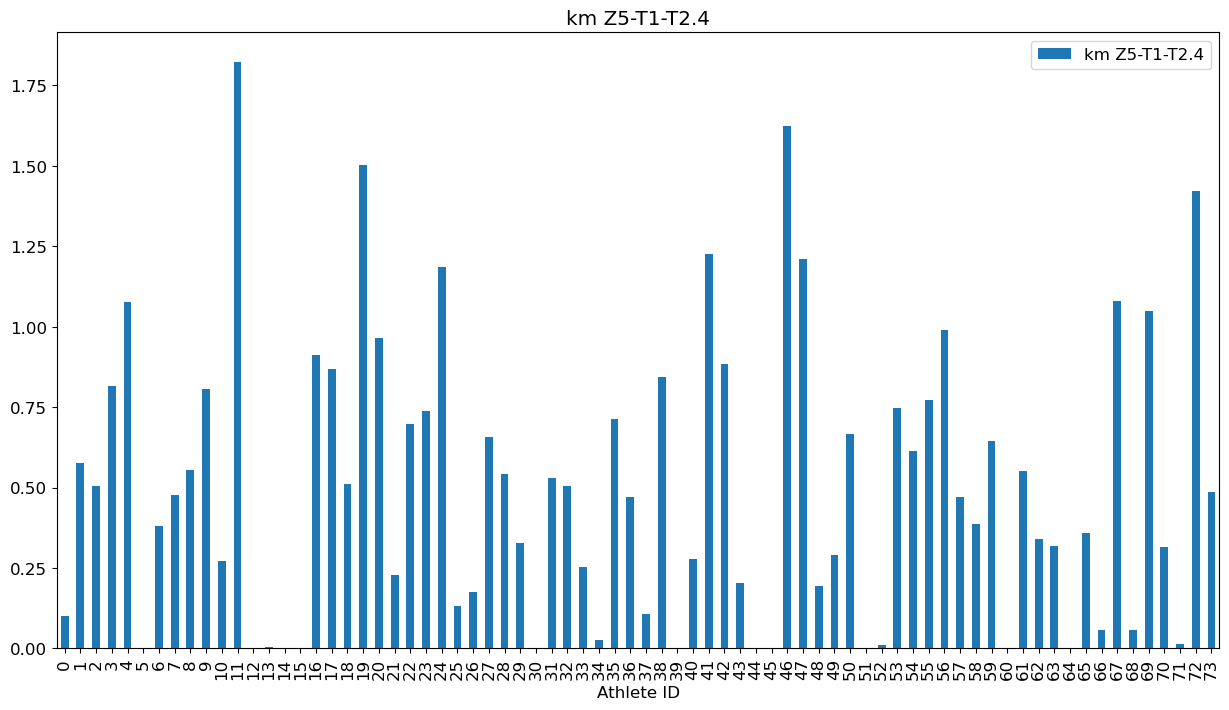

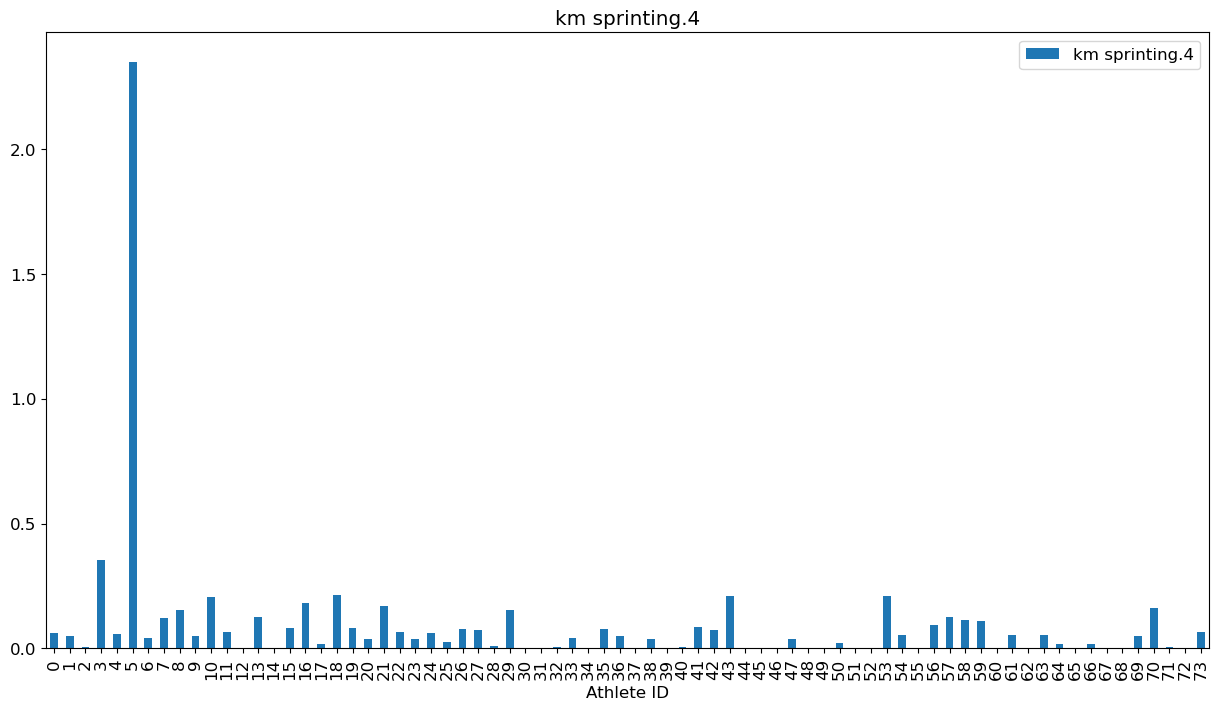

KeyboardInterrupt: 

In [25]:
# average training differences for different types of training:
sprint_cols = [col for col in df.columns if col.startswith('km')]
for col in sprint_cols:
    ave_df = df.groupby(['Athlete ID']).agg({col:'mean'}).reset_index()
    ave_df.plot.bar('Athlete ID',col, figsize = (15,8))
    plt.title(col)
    plt.show()

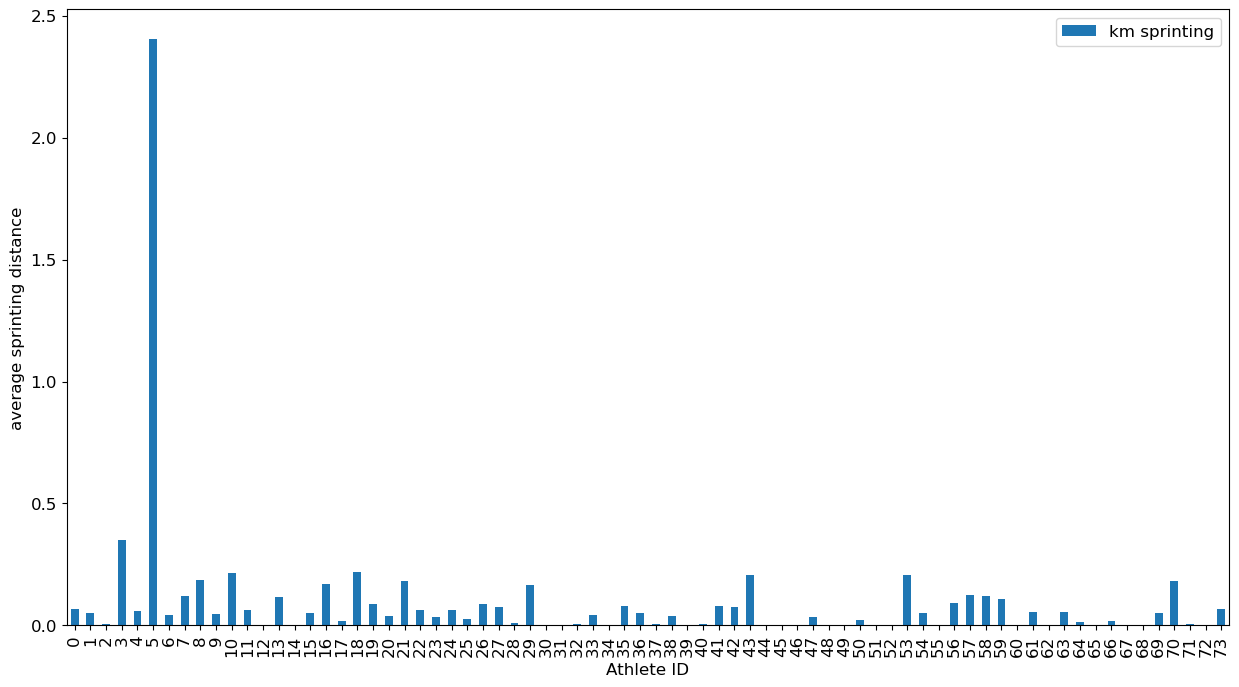

In [70]:
ave_sprinting = df.groupby(['Athlete ID']).agg({'km sprinting':'mean'}).reset_index()
ave_sprinting.plot.bar('Athlete ID','km sprinting', figsize = (15,8))
plt.ylabel('average sprinting distance')
plt.savefig('../figures/average_sprinting.png')
plt.show()

In [17]:
df5 = df[df['Athlete ID'] == 5]
print(np.sum(df5['km Z3-4']))
print(np.sum(df5['km Z5-T1-T2']))

0.0
0.0


### Found an outlier! ###

Athlete number 5 is definitely an outlier because their sprinting distance is abnormally higher, and seems like all of their distances were recorded as sprint, which is not really normal. It is not humanly possible to sprint for 40km, so they are either a superhero or their data was recorded incorrectly, either way I should remove them from the data set.

In [40]:
# remove outlier
df = df[df['Athlete ID'] != 5]

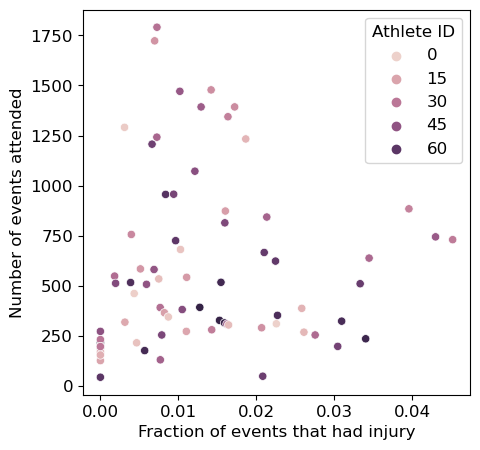

In [29]:
# find which athletes competed in a lot of games AND get injured more frequently
plt.figure(figsize=(5,5))
sns.scatterplot(data=perc_injured_per_athlete, x='perc_injury', y='Date', hue='Athlete ID')
plt.xlabel('Fraction of events that had injury')
plt.ylabel('Number of events attended')
plt.savefig('../figures/athlete scatter.png')

plt.show()

### EDA after excluding outlier athlete 5 ###

#### Explore the Features ####

focus on the features in nr. sessions (the session right before the event)

In [32]:
other_cols = ['Athlete ID','injury', 'Date']
cont_ftrs = [col for col in df if col not in other_cols]
cat_ftrs = ['Athlete ID']

nr. sessions
count    42766.000000
mean         0.829561
std          0.580696
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: nr. sessions, dtype: float64


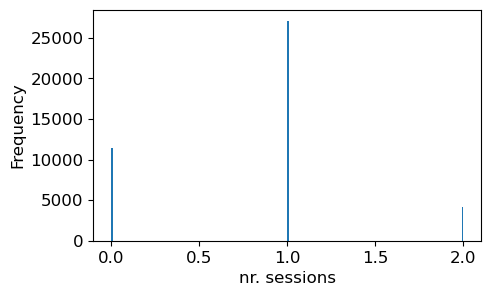

total km
count    42766.000000
mean         7.038187
std          7.473216
min          0.000000
25%          0.000000
50%          6.000000
75%         12.000000
max         55.900000
Name: total km, dtype: float64


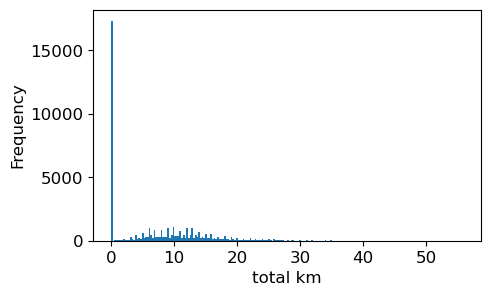

km Z3-4
count    42766.000000
mean         0.691381
std          2.317657
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         42.200000
Name: km Z3-4, dtype: float64


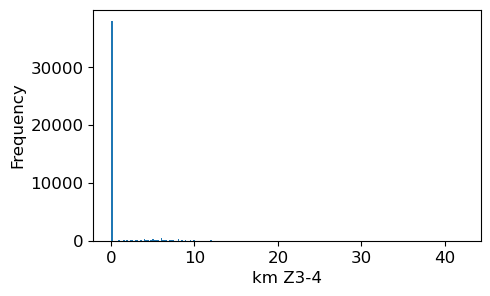

km Z5-T1-T2
count    42766.000000
mean         0.579930
std          1.811938
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         48.000000
Name: km Z5-T1-T2, dtype: float64


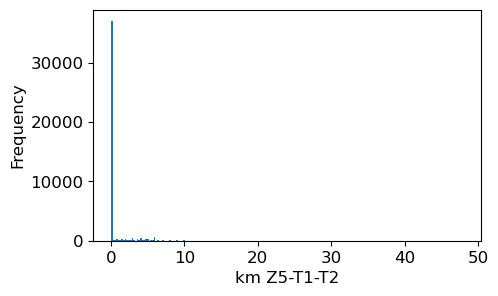

km sprinting
count    42766.000000
mean         0.073016
std          0.483480
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         40.000000
Name: km sprinting, dtype: float64


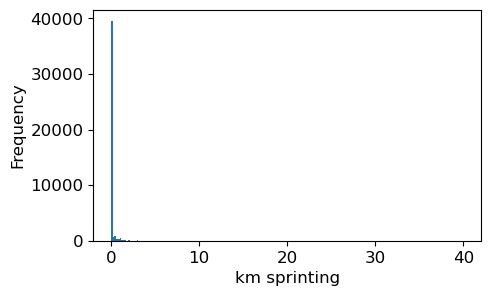

strength training
count    42766.000000
mean         0.116237
std          0.326010
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: strength training, dtype: float64


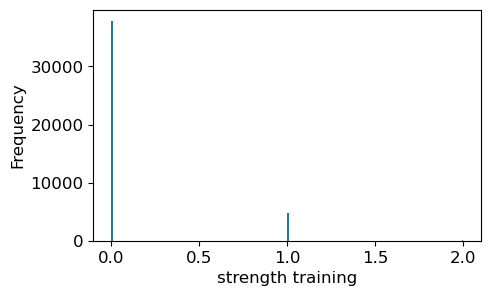

hours alternative
count    42766.000000
mean         0.163492
std          0.549664
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.220000
Name: hours alternative, dtype: float64


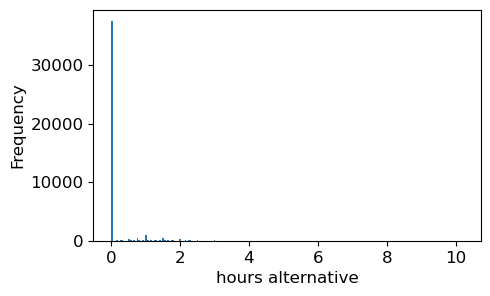

perceived exertion
count    42766.000000
mean         0.247788
std          0.257262
min         -0.010000
25%         -0.010000
50%          0.160000
75%          0.440000
max          1.000000
Name: perceived exertion, dtype: float64


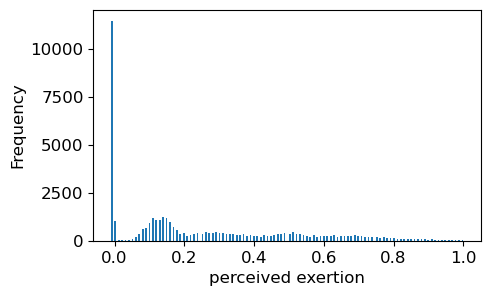

perceived trainingSuccess
count    42766.000000
mean         0.349802
std          0.368300
min         -0.010000
25%         -0.010000
50%          0.260000
75%          0.720000
max          1.000000
Name: perceived trainingSuccess, dtype: float64


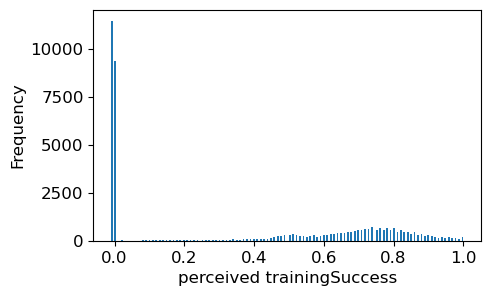

perceived recovery
count    42766.000000
mean         0.195898
std          0.190321
min         -0.010000
25%         -0.010000
50%          0.160000
75%          0.300000
max          1.000000
Name: perceived recovery, dtype: float64


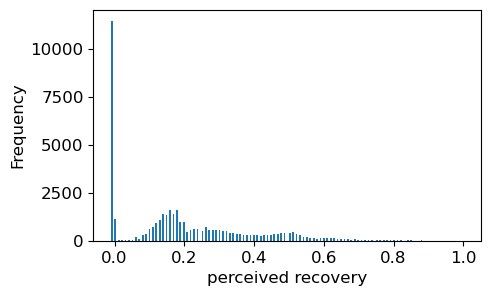

nr. sessions.1
count    42766.000000
mean         0.829000
std          0.581215
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: nr. sessions.1, dtype: float64


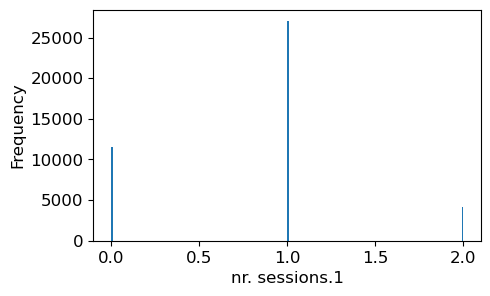

total km.1
count    42766.000000
mean         7.024199
std          7.473041
min          0.000000
25%          0.000000
50%          6.000000
75%         12.000000
max         55.900000
Name: total km.1, dtype: float64


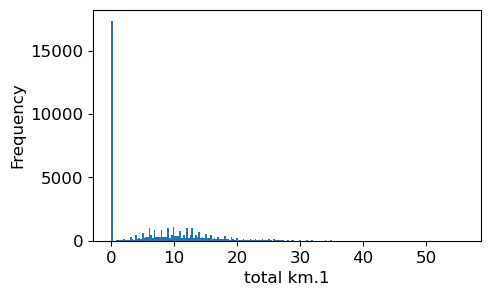

km Z3-4.1
count    42766.000000
mean         0.689436
std          2.310966
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         42.200000
Name: km Z3-4.1, dtype: float64


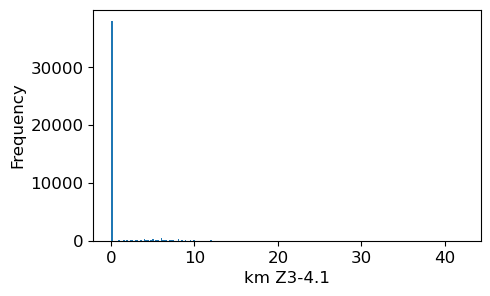

km Z5-T1-T2.1
count    42766.000000
mean         0.574926
std          1.805558
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         48.000000
Name: km Z5-T1-T2.1, dtype: float64


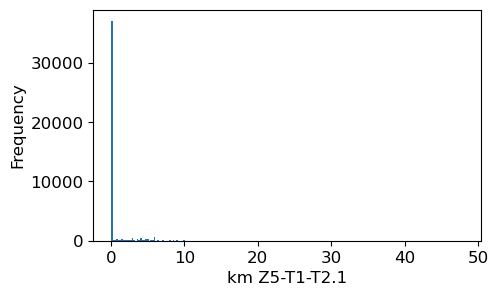

km sprinting.1
count    42766.000000
mean         0.072614
std          0.484186
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         40.000000
Name: km sprinting.1, dtype: float64


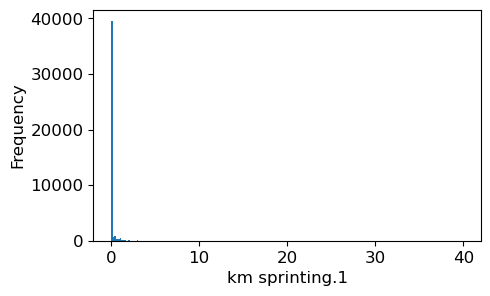

strength training.1
count    42766.000000
mean         0.117126
std          0.327197
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: strength training.1, dtype: float64


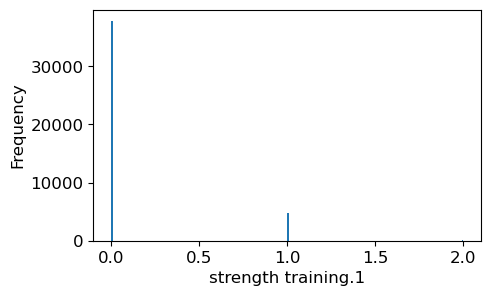

hours alternative.1
count    42766.000000
mean         0.164331
std          0.552471
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.220000
Name: hours alternative.1, dtype: float64


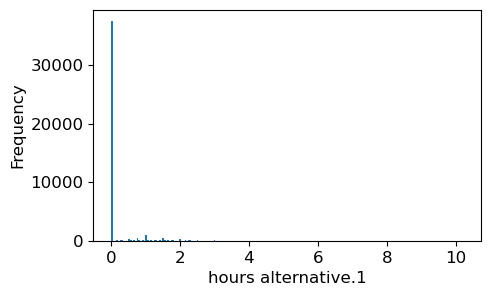

perceived exertion.1
count    42766.000000
mean         0.247228
std          0.256781
min         -0.010000
25%         -0.010000
50%          0.160000
75%          0.440000
max          1.000000
Name: perceived exertion.1, dtype: float64


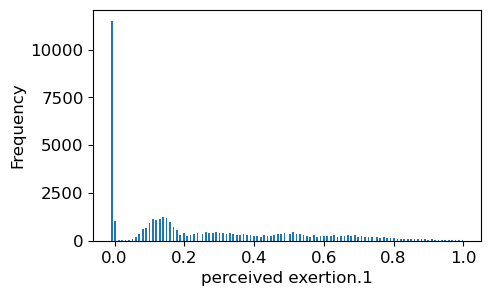

perceived trainingSuccess.1
count    42766.000000
mean         0.349327
std          0.368236
min         -0.010000
25%         -0.010000
50%          0.250000
75%          0.720000
max          1.000000
Name: perceived trainingSuccess.1, dtype: float64


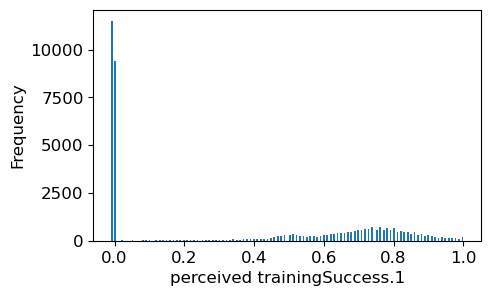

perceived recovery.1
count    42766.000000
mean         0.195780
std          0.190313
min         -0.010000
25%         -0.010000
50%          0.160000
75%          0.300000
max          1.000000
Name: perceived recovery.1, dtype: float64


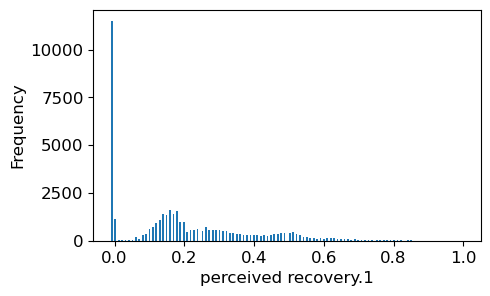

nr. sessions.2
count    42766.000000
mean         0.829561
std          0.580736
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: nr. sessions.2, dtype: float64


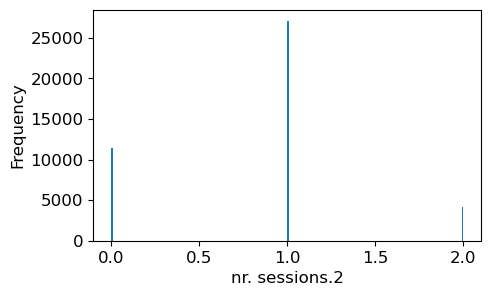

total km.2
count    42766.000000
mean         7.039143
std          7.470759
min          0.000000
25%          0.000000
50%          6.000000
75%         12.000000
max         55.900000
Name: total km.2, dtype: float64


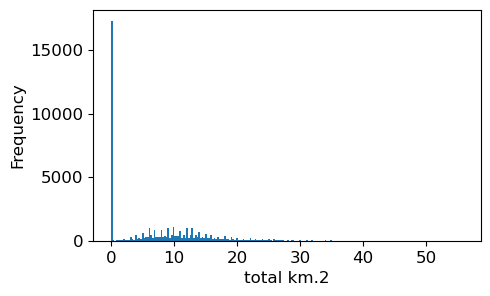

km Z3-4.2
count    42766.000000
mean         0.695195
std          2.328649
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         42.200000
Name: km Z3-4.2, dtype: float64


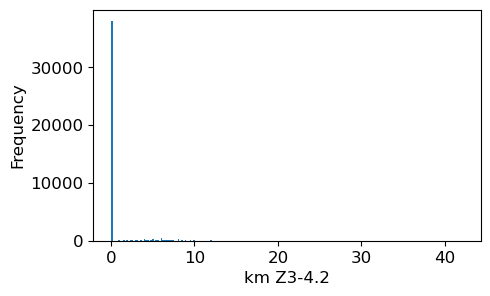

km Z5-T1-T2.2
count    42766.000000
mean         0.578438
std          1.808320
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         48.000000
Name: km Z5-T1-T2.2, dtype: float64


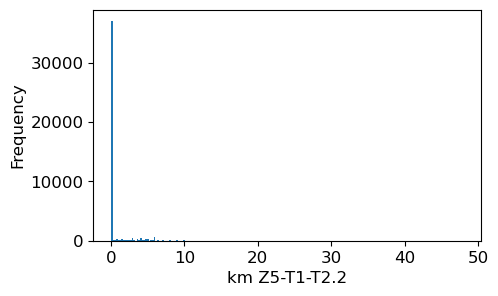

km sprinting.2
count    42766.000000
mean         0.073135
std          0.485633
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         40.000000
Name: km sprinting.2, dtype: float64


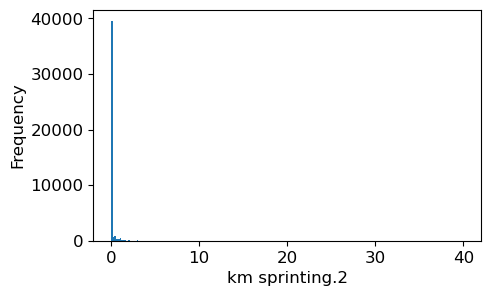

strength training.2
count    42766.000000
mean         0.116518
std          0.326699
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: strength training.2, dtype: float64


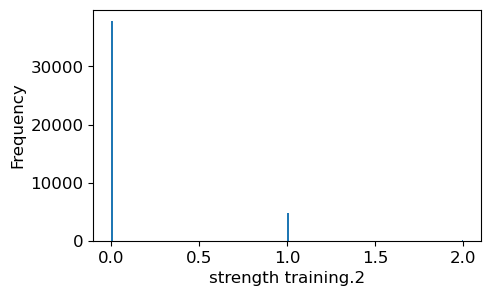

hours alternative.2
count    42766.000000
mean         0.163359
std          0.550724
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.220000
Name: hours alternative.2, dtype: float64


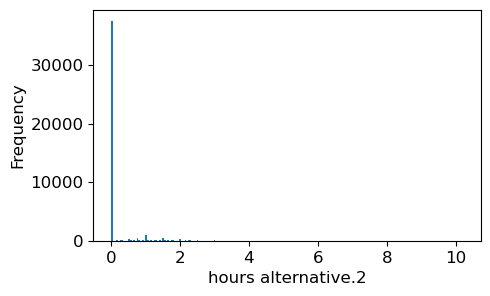

perceived exertion.2
count    42766.000000
mean         0.247726
std          0.257149
min         -0.010000
25%         -0.010000
50%          0.160000
75%          0.440000
max          1.000000
Name: perceived exertion.2, dtype: float64


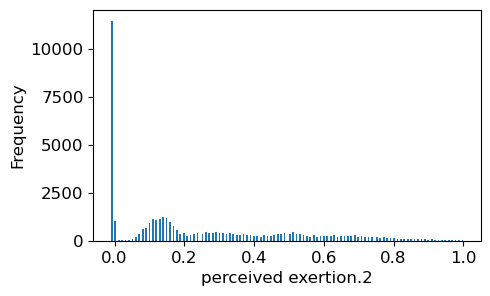

perceived trainingSuccess.2
count    42766.000000
mean         0.349382
std          0.368063
min         -0.010000
25%         -0.010000
50%          0.260000
75%          0.720000
max          1.000000
Name: perceived trainingSuccess.2, dtype: float64


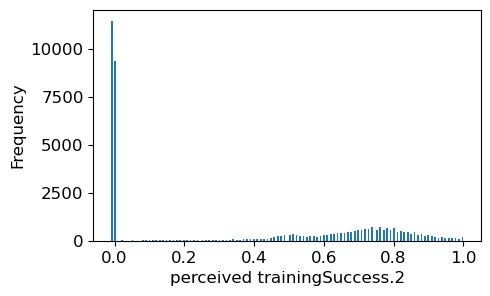

perceived recovery.2
count    42766.000000
mean         0.196104
std          0.190505
min         -0.010000
25%         -0.010000
50%          0.160000
75%          0.300000
max          1.000000
Name: perceived recovery.2, dtype: float64


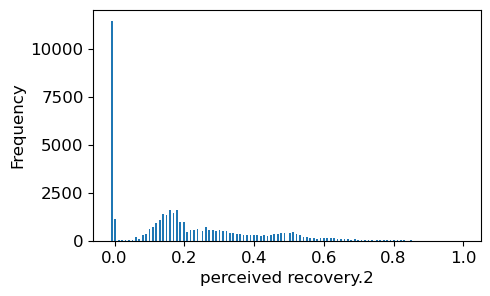

nr. sessions.3
count    42766.000000
mean         0.829280
std          0.580533
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: nr. sessions.3, dtype: float64


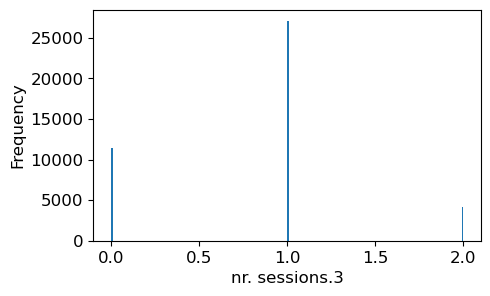

total km.3
count    42766.000000
mean         7.039936
std          7.464805
min          0.000000
25%          0.000000
50%          6.000000
75%         12.000000
max         57.000000
Name: total km.3, dtype: float64


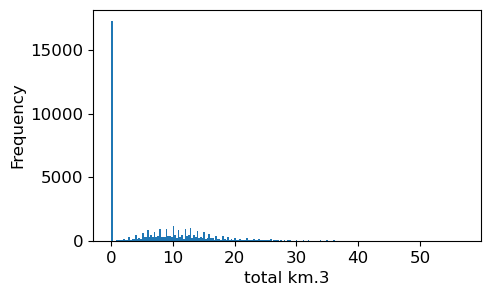

km Z3-4.3
count    42766.000000
mean         0.692611
std          2.315000
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         42.200000
Name: km Z3-4.3, dtype: float64


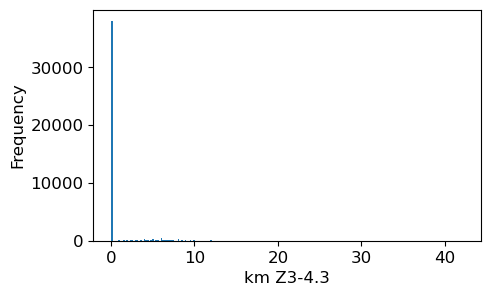

km Z5-T1-T2.3
count    42766.000000
mean         0.578181
std          1.810760
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         48.000000
Name: km Z5-T1-T2.3, dtype: float64


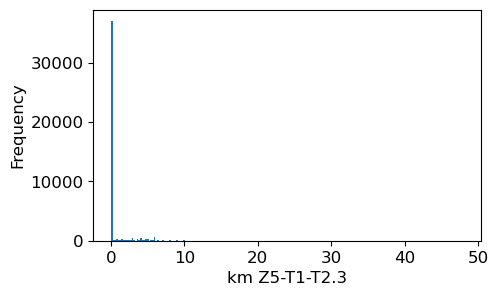

km sprinting.3
count    42766.000000
mean         0.072693
std          0.481981
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         40.000000
Name: km sprinting.3, dtype: float64


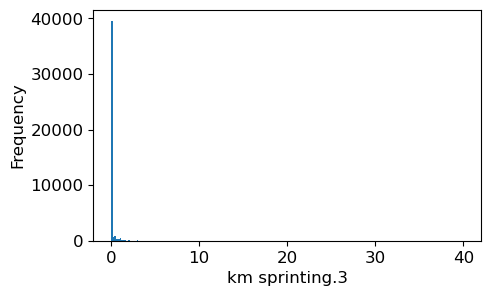

strength training.3
count    42766.000000
mean         0.116307
std          0.326380
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: strength training.3, dtype: float64


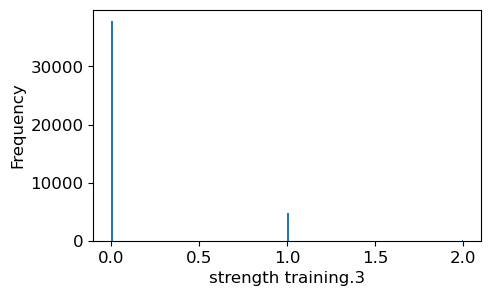

hours alternative.3
count    42766.000000
mean         0.162977
std          0.548887
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.220000
Name: hours alternative.3, dtype: float64


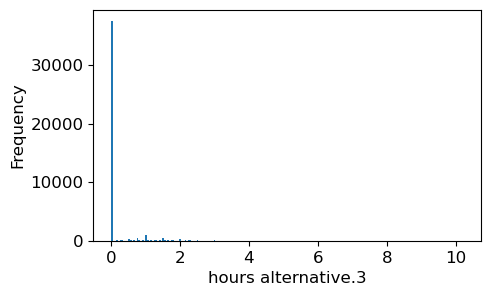

perceived exertion.3
count    42766.000000
mean         0.247664
std          0.257077
min         -0.010000
25%         -0.010000
50%          0.160000
75%          0.440000
max          1.000000
Name: perceived exertion.3, dtype: float64


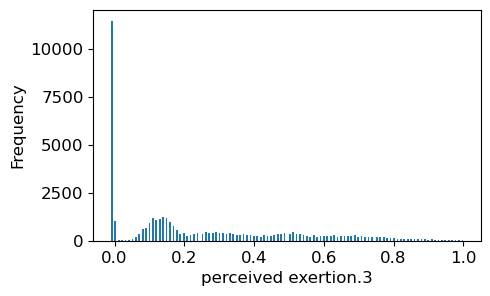

perceived trainingSuccess.3
count    42766.000000
mean         0.349609
std          0.368157
min         -0.010000
25%         -0.010000
50%          0.260000
75%          0.720000
max          1.000000
Name: perceived trainingSuccess.3, dtype: float64


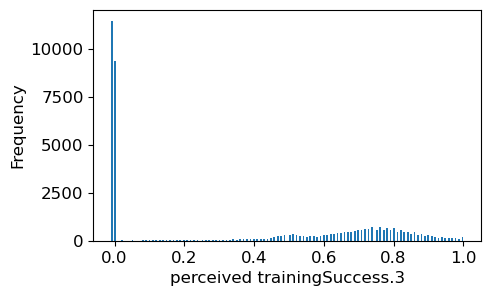

perceived recovery.3
count    42766.000000
mean         0.196164
std          0.190568
min         -0.010000
25%         -0.010000
50%          0.160000
75%          0.300000
max          1.000000
Name: perceived recovery.3, dtype: float64


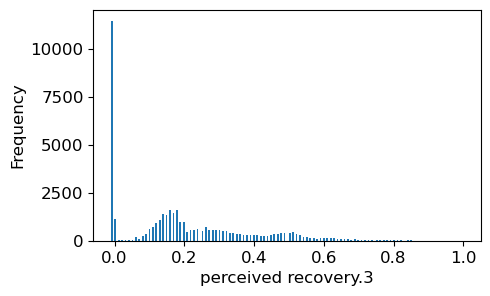

nr. sessions.4
count    42766.000000
mean         0.829865
std          0.580321
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: nr. sessions.4, dtype: float64


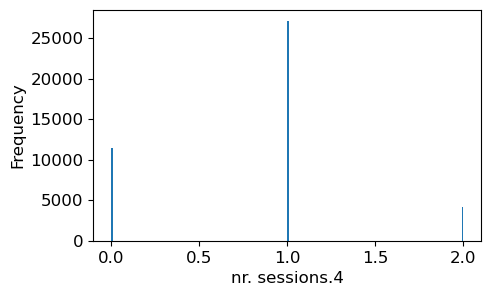

total km.4
count    42766.000000
mean         7.042934
std          7.461837
min          0.000000
25%          0.000000
50%          6.000000
75%         12.000000
max         55.900000
Name: total km.4, dtype: float64


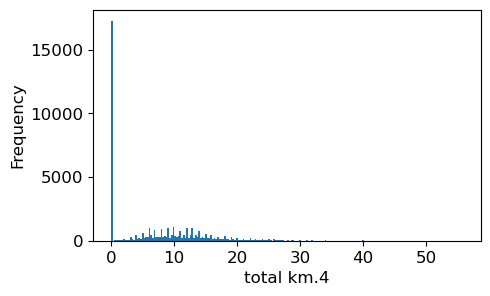

km Z3-4.4
count    42766.000000
mean         0.695447
std          2.324751
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         42.200000
Name: km Z3-4.4, dtype: float64


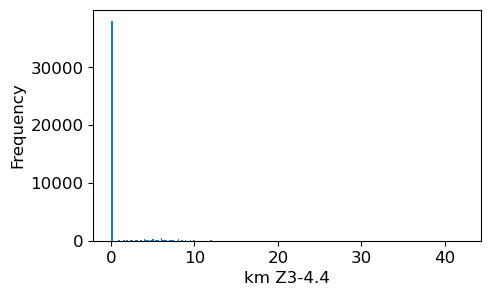

km Z5-T1-T2.4
count    42766.000000
mean         0.577788
std          1.807505
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         48.000000
Name: km Z5-T1-T2.4, dtype: float64


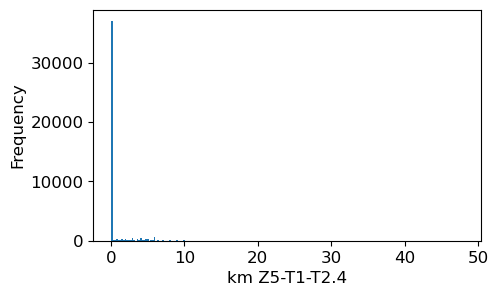

km sprinting.4
count    42766.000000
mean         0.072167
std          0.479745
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         40.000000
Name: km sprinting.4, dtype: float64


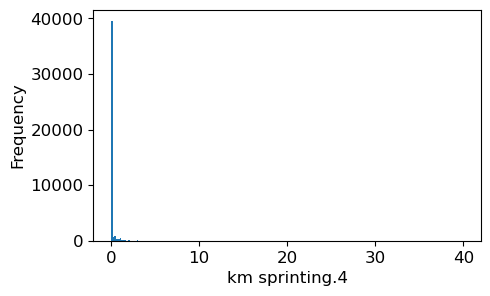

strength training.4
count    42766.000000
mean         0.116214
std          0.326270
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: strength training.4, dtype: float64


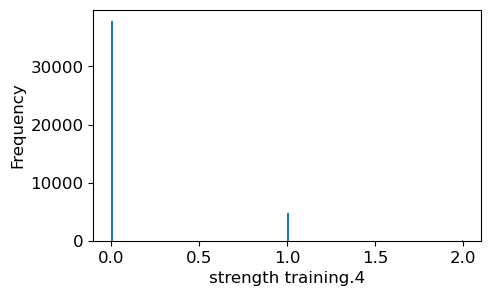

hours alternative.4
count    42766.000000
mean         0.162675
std          0.546884
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: hours alternative.4, dtype: float64


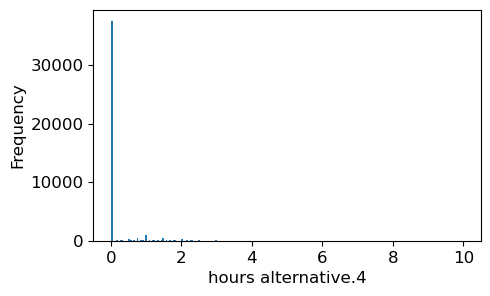

perceived exertion.4
count    42766.000000
mean         0.247642
std          0.256785
min         -0.010000
25%         -0.010000
50%          0.160000
75%          0.440000
max          1.000000
Name: perceived exertion.4, dtype: float64


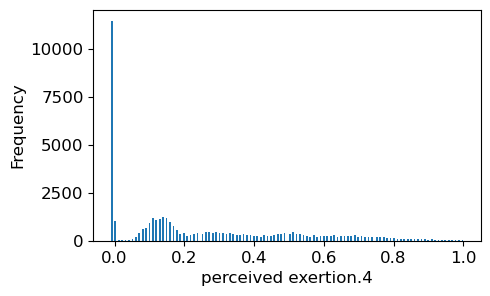

perceived trainingSuccess.4
count    42766.000000
mean         0.349797
std          0.368123
min         -0.010000
25%         -0.010000
50%          0.260000
75%          0.720000
max          1.000000
Name: perceived trainingSuccess.4, dtype: float64


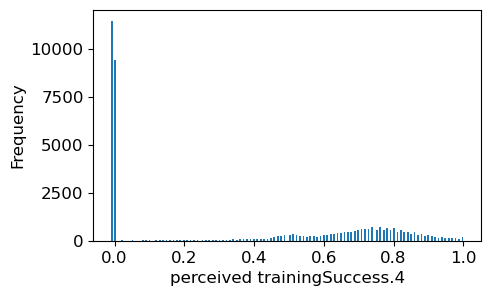

perceived recovery.4
count    42766.000000
mean         0.196250
std          0.190499
min         -0.010000
25%         -0.010000
50%          0.170000
75%          0.300000
max          1.000000
Name: perceived recovery.4, dtype: float64


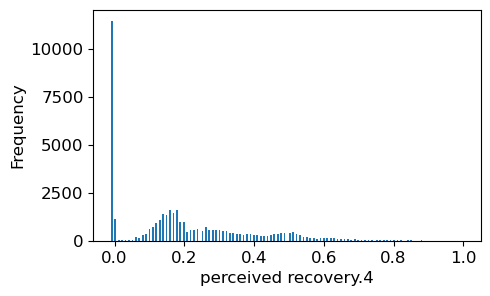

nr. sessions.5
count    42766.000000
mean         0.828766
std          0.579696
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: nr. sessions.5, dtype: float64


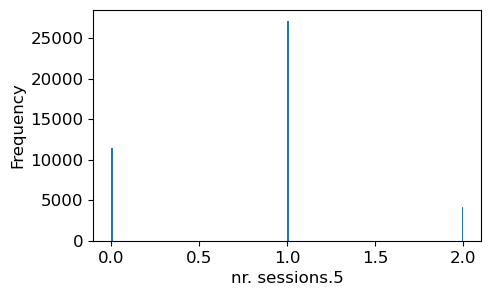

total km.5
count    42766.000000
mean         7.054684
std          7.470514
min          0.000000
25%          0.000000
50%          6.000000
75%         12.000000
max         55.900000
Name: total km.5, dtype: float64


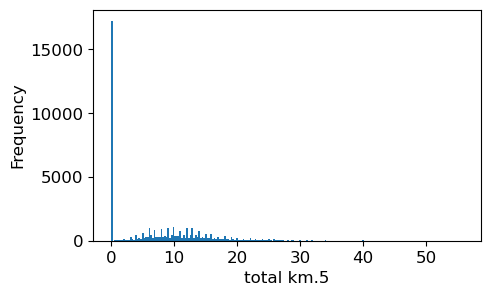

km Z3-4.5
count    42766.000000
mean         0.697388
std          2.327571
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         42.200000
Name: km Z3-4.5, dtype: float64


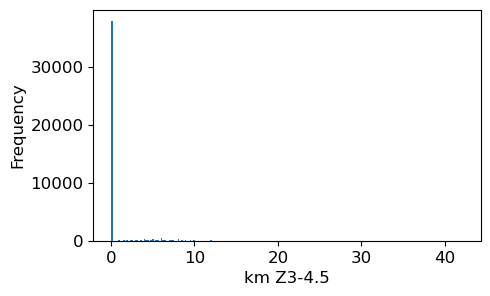

km Z5-T1-T2.5
count    42766.000000
mean         0.580073
std          1.811543
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         48.000000
Name: km Z5-T1-T2.5, dtype: float64


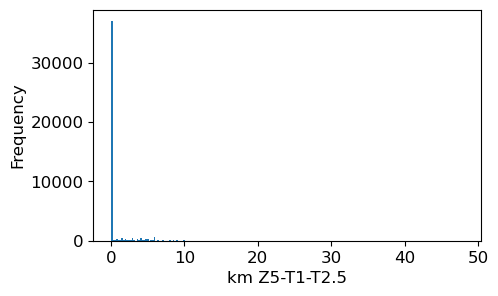

km sprinting.5
count    42766.000000
mean         0.072303
std          0.487074
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         40.000000
Name: km sprinting.5, dtype: float64


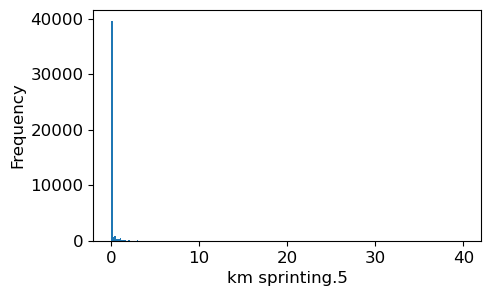

strength training.5
count    42766.000000
mean         0.115886
std          0.325741
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: strength training.5, dtype: float64


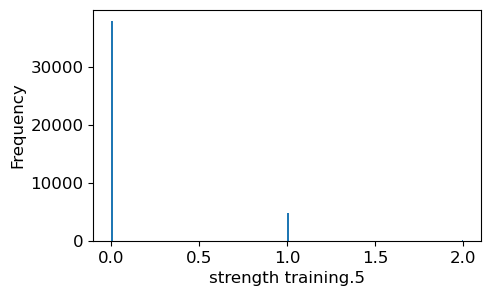

hours alternative.5
count    42766.000000
mean         0.161330
std          0.544333
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: hours alternative.5, dtype: float64


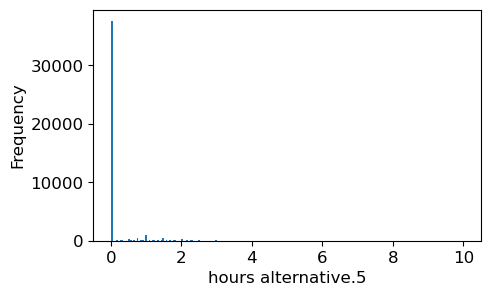

perceived exertion.5
count    42766.000000
mean         0.247697
std          0.256950
min         -0.010000
25%         -0.010000
50%          0.160000
75%          0.440000
max          1.000000
Name: perceived exertion.5, dtype: float64


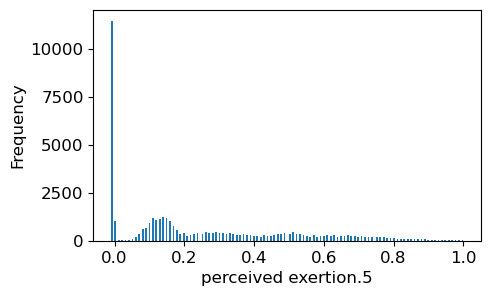

perceived trainingSuccess.5
count    42766.000000
mean         0.349669
std          0.368109
min         -0.010000
25%         -0.010000
50%          0.260000
75%          0.720000
max          1.000000
Name: perceived trainingSuccess.5, dtype: float64


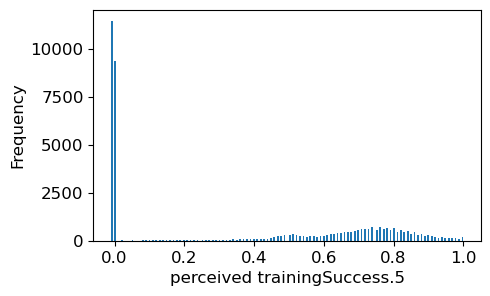

perceived recovery.5
count    42766.000000
mean         0.196298
std          0.190694
min         -0.010000
25%         -0.010000
50%          0.170000
75%          0.300000
max          1.000000
Name: perceived recovery.5, dtype: float64


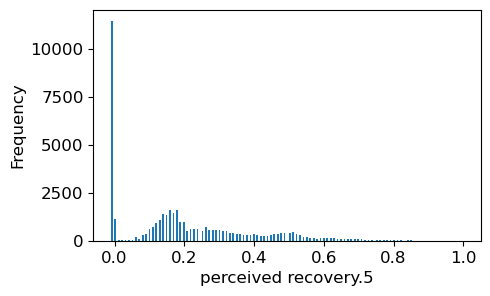

nr. sessions.6
count    42766.000000
mean         0.828813
std          0.579951
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: nr. sessions.6, dtype: float64


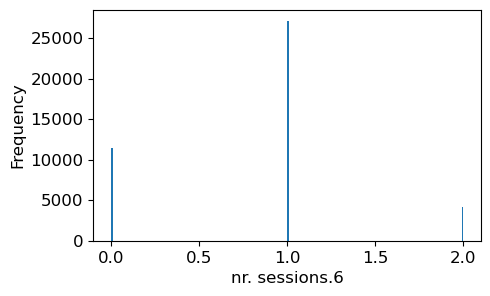

total km.6
count    42766.000000
mean         7.051319
std          7.470174
min          0.000000
25%          0.000000
50%          6.000000
75%         12.000000
max         55.900000
Name: total km.6, dtype: float64


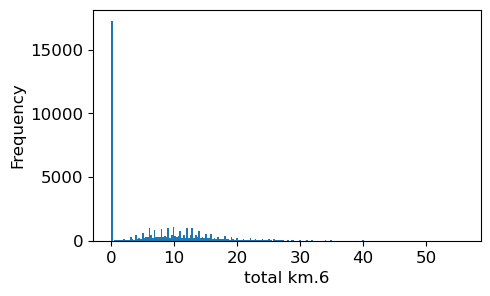

km Z3-4.6
count    42766.000000
mean         0.695031
std          2.323844
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         42.200000
Name: km Z3-4.6, dtype: float64


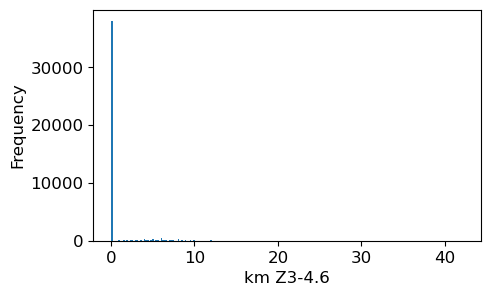

km Z5-T1-T2.6
count    42766.000000
mean         0.580347
std          1.814538
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         48.000000
Name: km Z5-T1-T2.6, dtype: float64


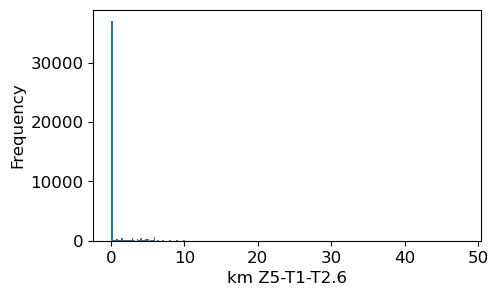

km sprinting.6
count    42766.000000
mean         0.072595
std          0.483691
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         40.000000
Name: km sprinting.6, dtype: float64


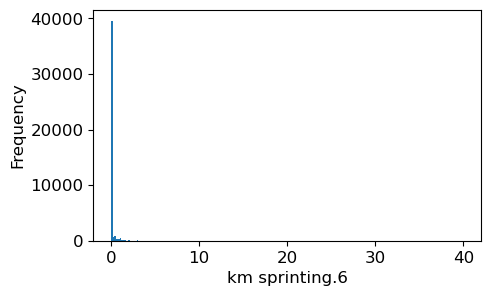

strength training.6
count    42766.000000
mean         0.116120
std          0.326016
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: strength training.6, dtype: float64


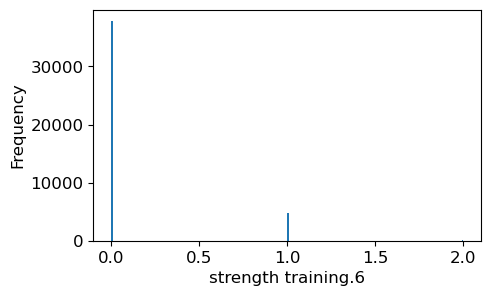

hours alternative.6
count    42766.000000
mean         0.162308
std          0.554031
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         20.000000
Name: hours alternative.6, dtype: float64


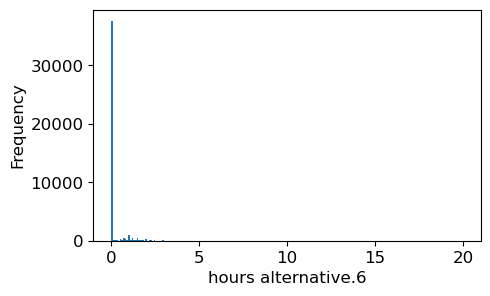

perceived exertion.6
count    42766.000000
mean         0.247550
std          0.256718
min         -0.010000
25%         -0.010000
50%          0.160000
75%          0.440000
max          1.000000
Name: perceived exertion.6, dtype: float64


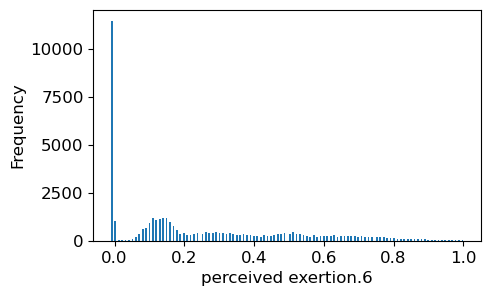

perceived trainingSuccess.6
count    42766.000000
mean         0.349503
std          0.368042
min         -0.010000
25%         -0.010000
50%          0.260000
75%          0.720000
max          1.000000
Name: perceived trainingSuccess.6, dtype: float64


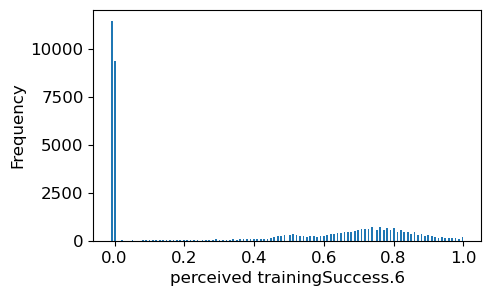

perceived recovery.6
count    42766.000000
mean         0.196224
std          0.190568
min         -0.010000
25%         -0.010000
50%          0.170000
75%          0.300000
max          1.000000
Name: perceived recovery.6, dtype: float64


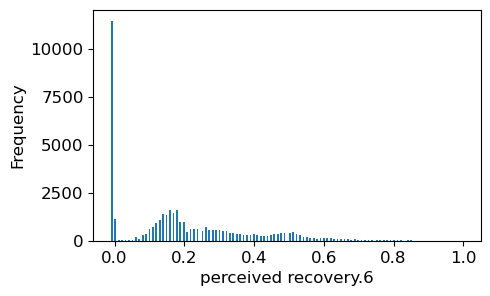

Athlete ID
count    42766.000000
mean        34.550858
std         19.050033
min          0.000000
25%         20.000000
50%         34.000000
75%         50.000000
max         73.000000
Name: Athlete ID, dtype: float64


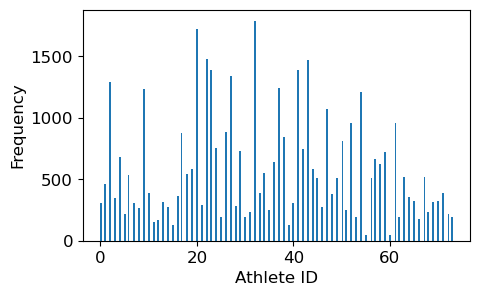

injury
count    42766.000000
mean         0.013632
std          0.115960
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: injury, dtype: float64


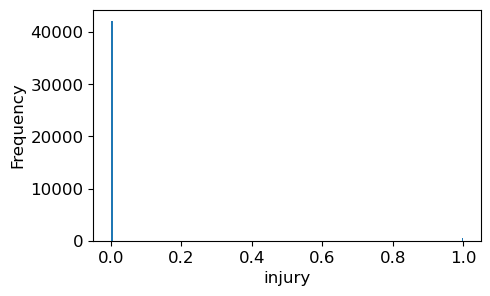

Date
count    42766.000000
mean      1228.039892
std        807.021168
min          0.000000
25%        436.000000
50%       1256.000000
75%       1913.000000
max       2673.000000
Name: Date, dtype: float64


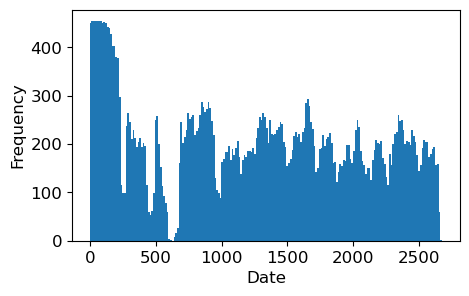

In [34]:
for ftr in df.columns:
    print(ftr)
    print(df[ftr].describe())
    plt.figure(figsize=(5,3))
    plt.hist(df[ftr], bins = int(np.sqrt(df.shape[0])))
    plt.xlabel(ftr)
    plt.ylabel('Frequency')
    plt.savefig('../figures/{}.png'.format(ftr))
    plt.show()

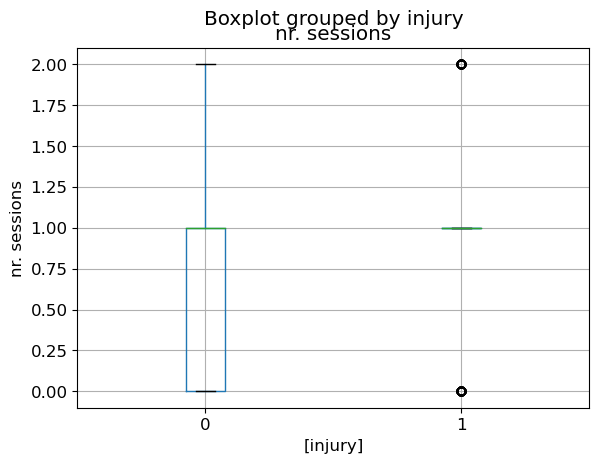

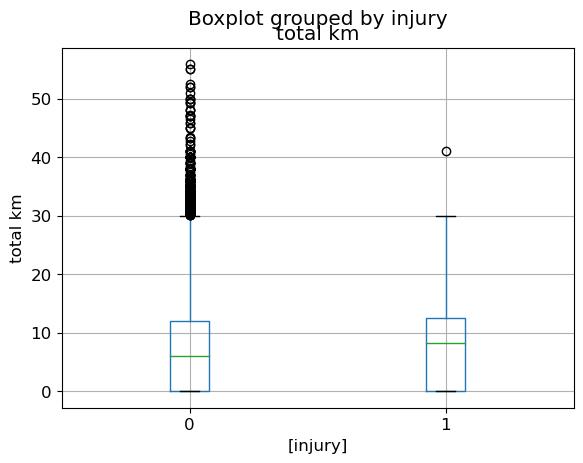

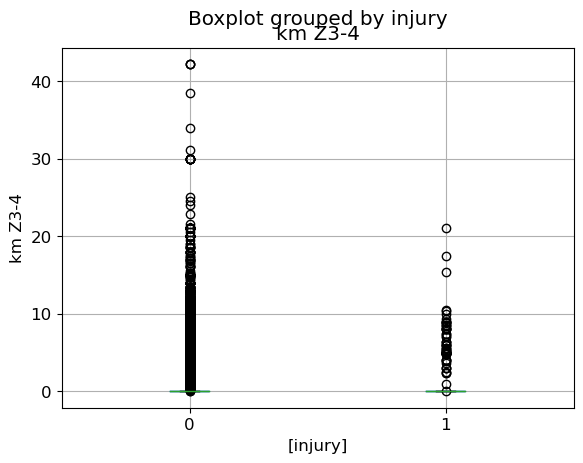

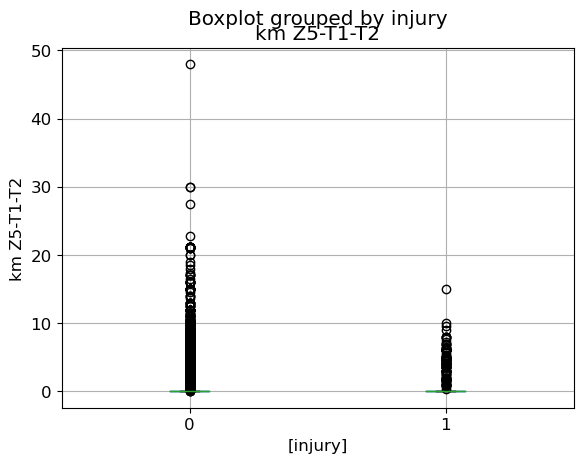

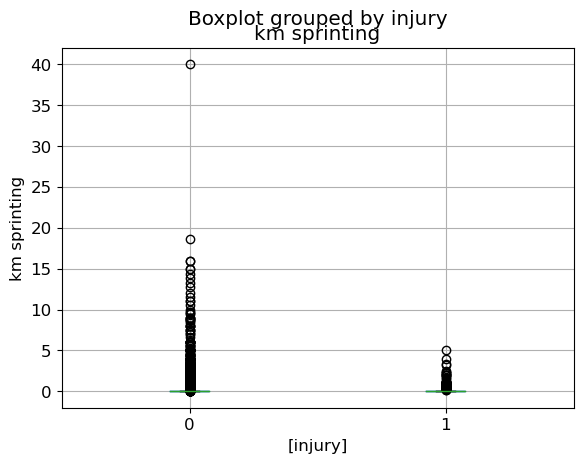

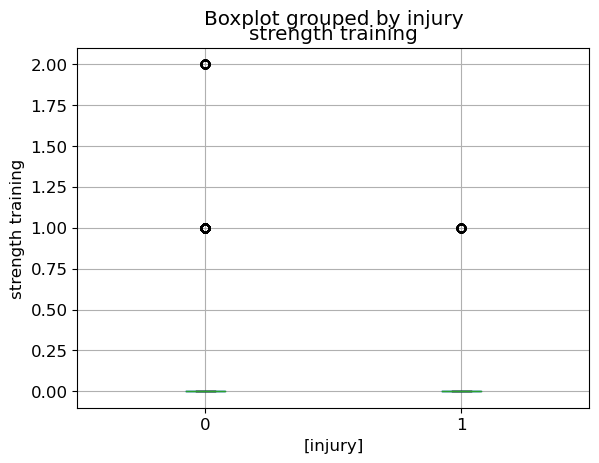

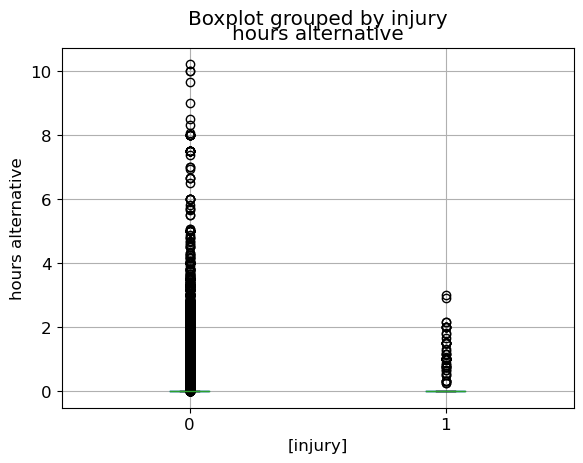

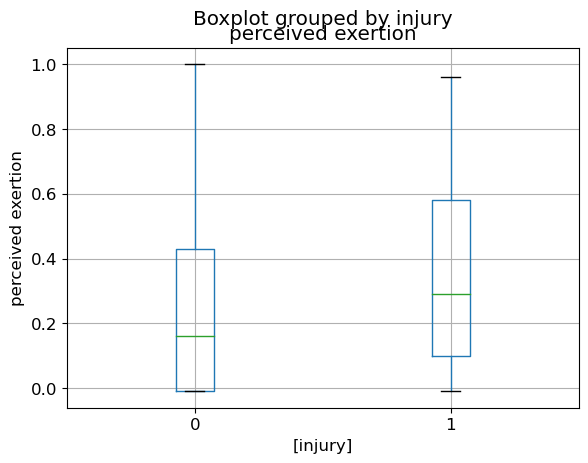

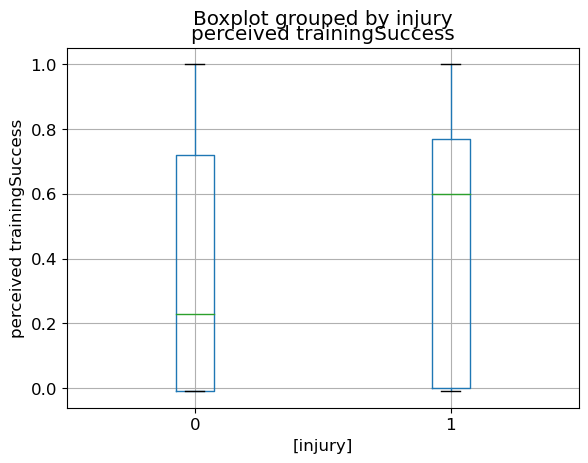

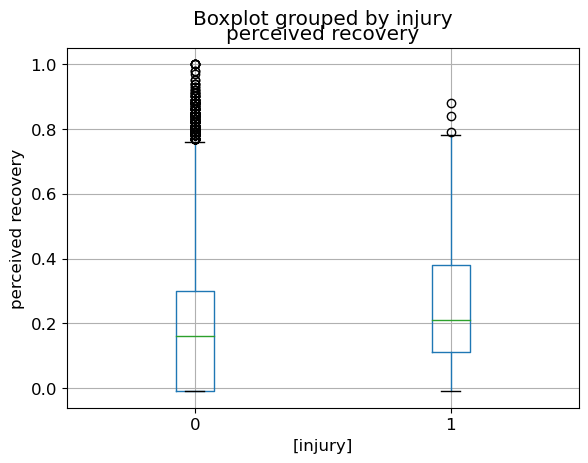

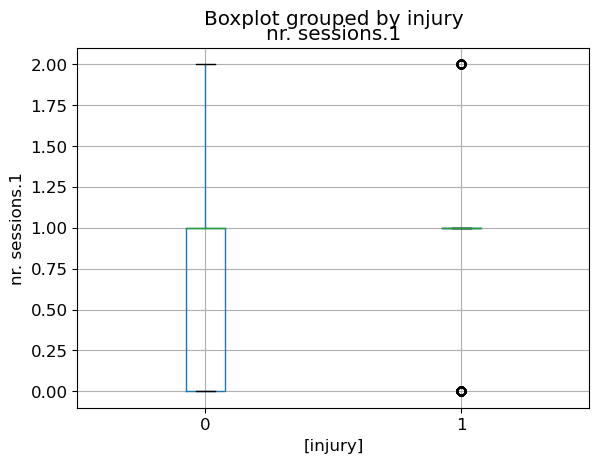

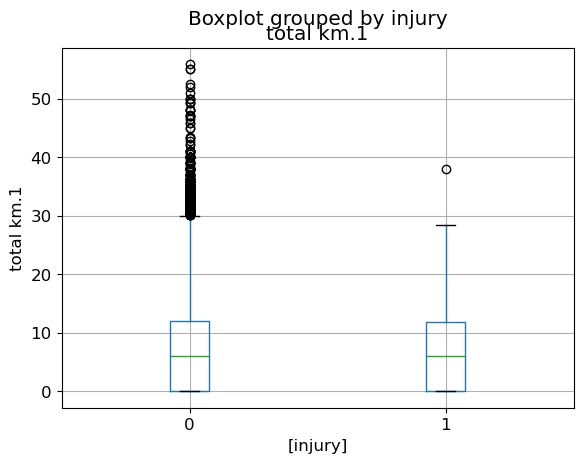

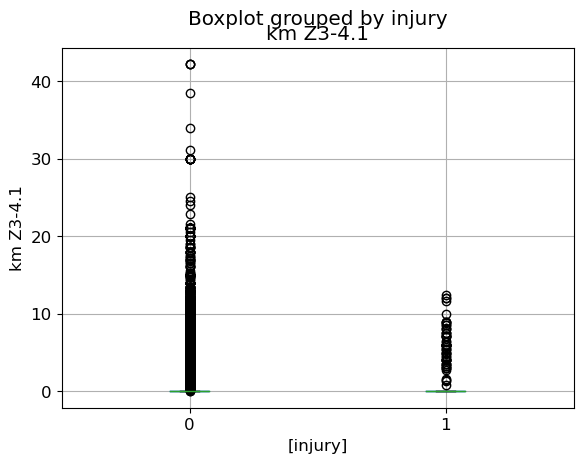

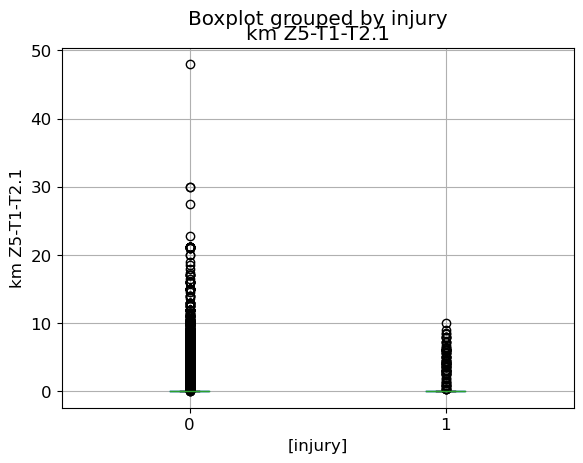

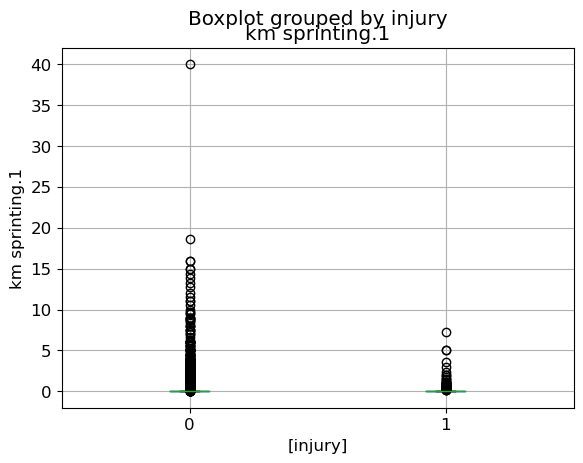

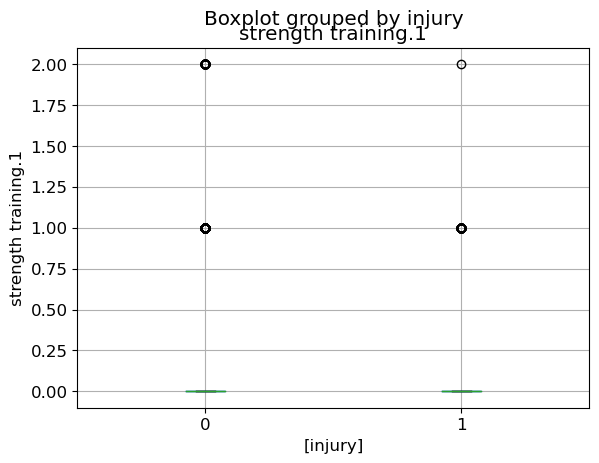

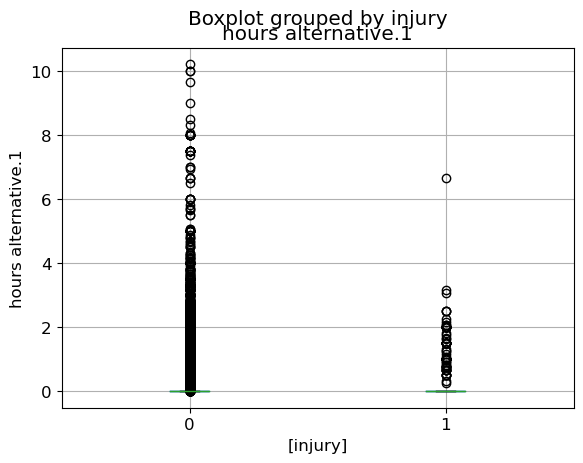

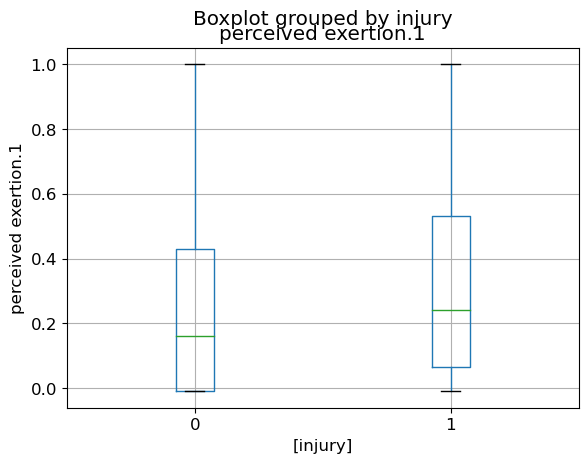

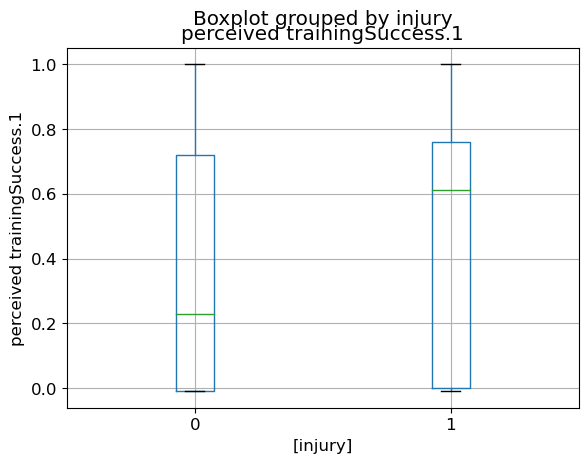

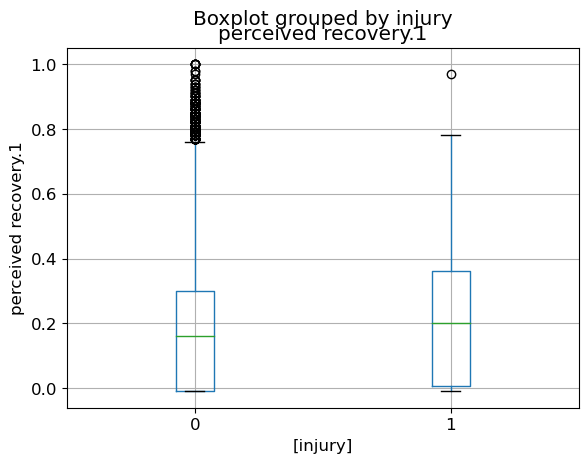

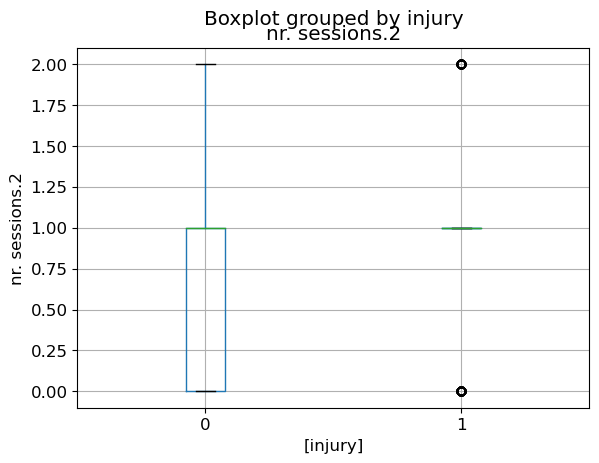

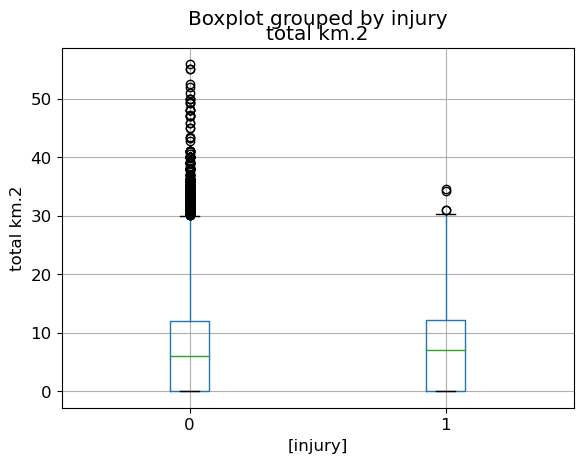

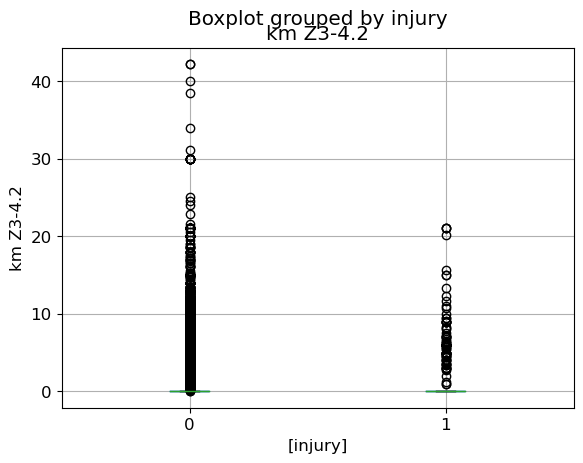

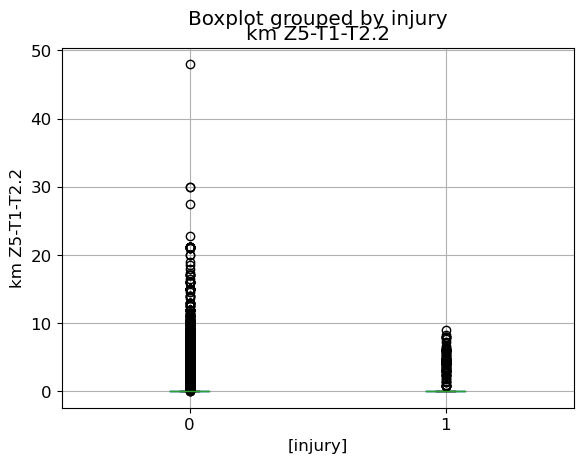

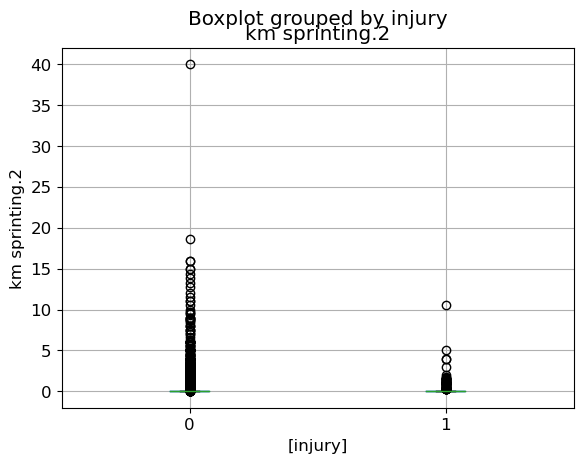

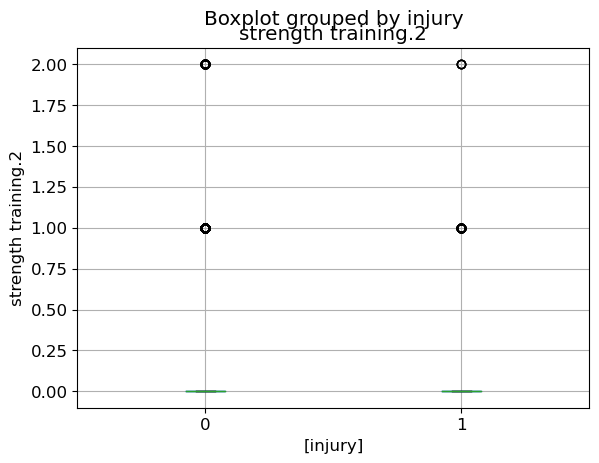

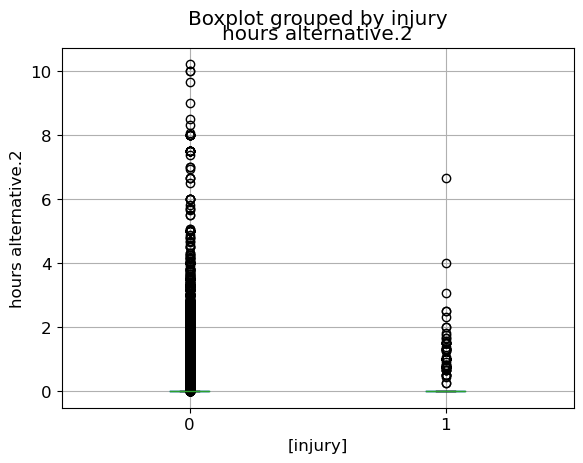

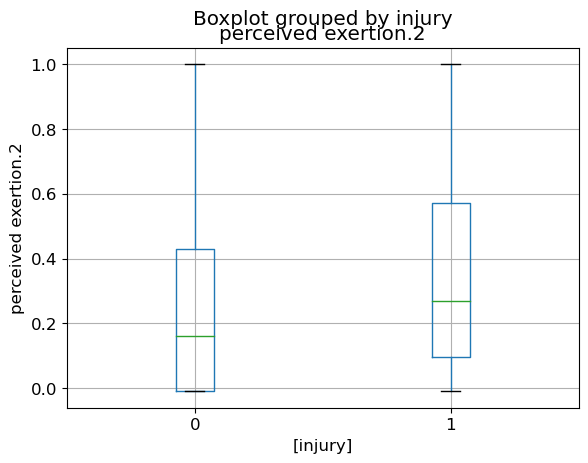

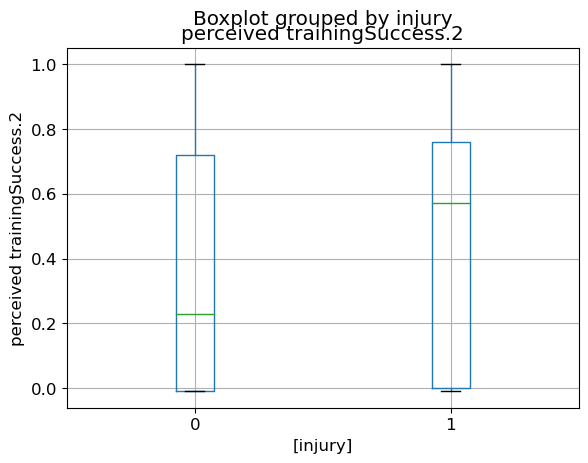

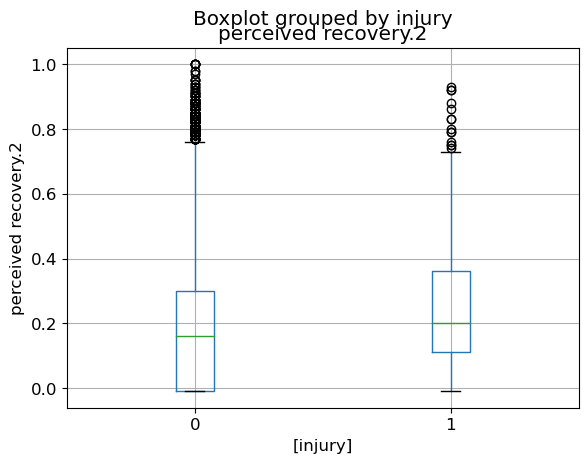

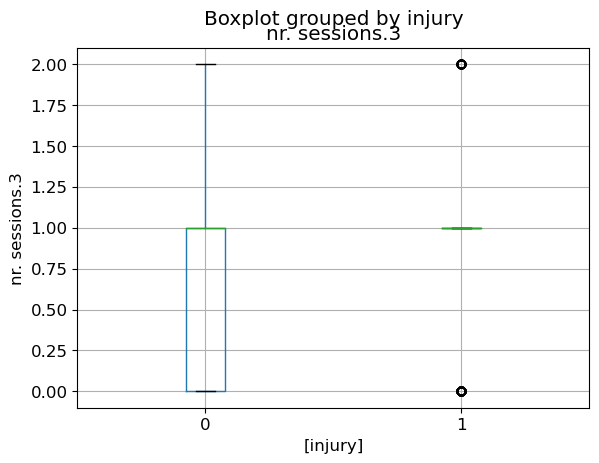

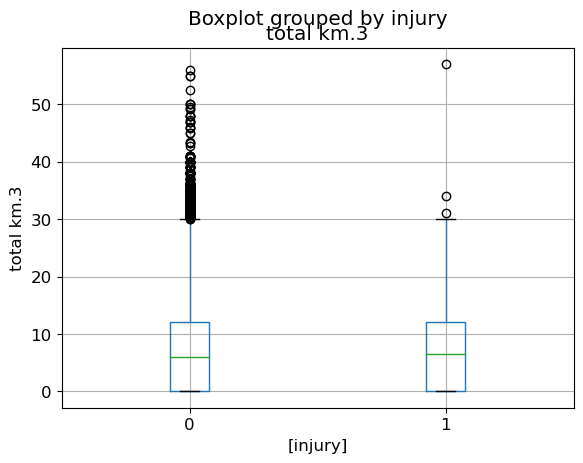

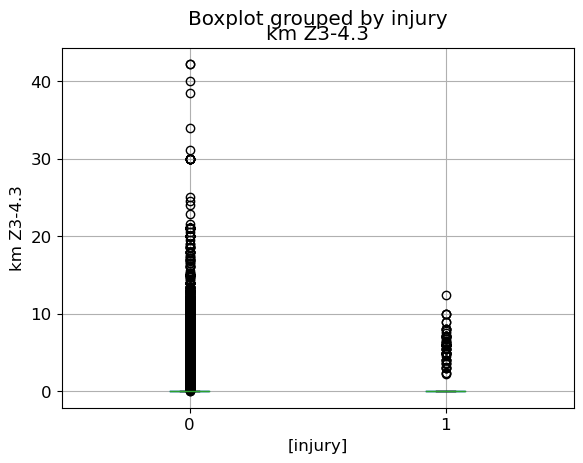

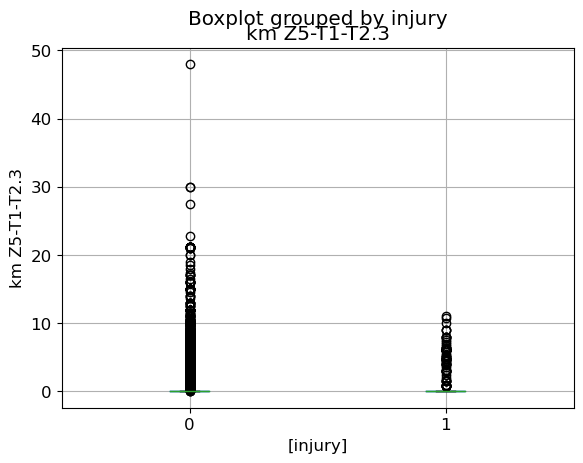

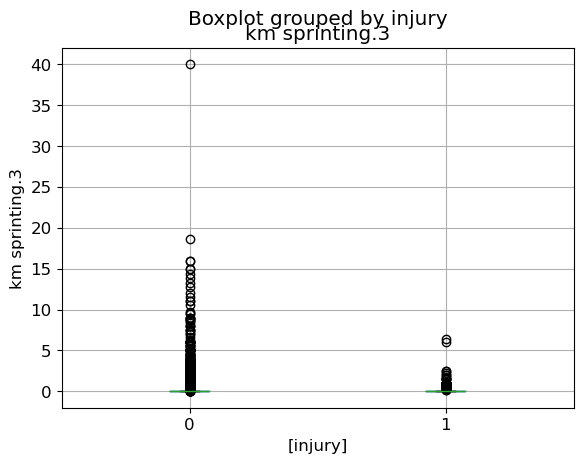

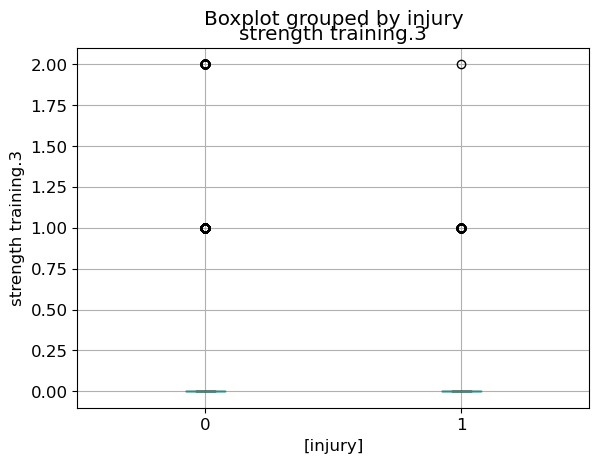

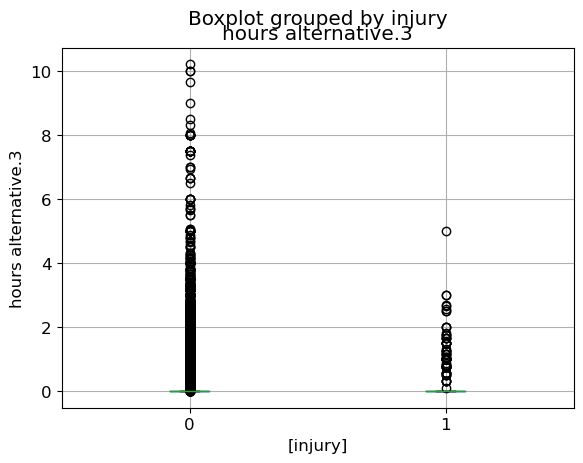

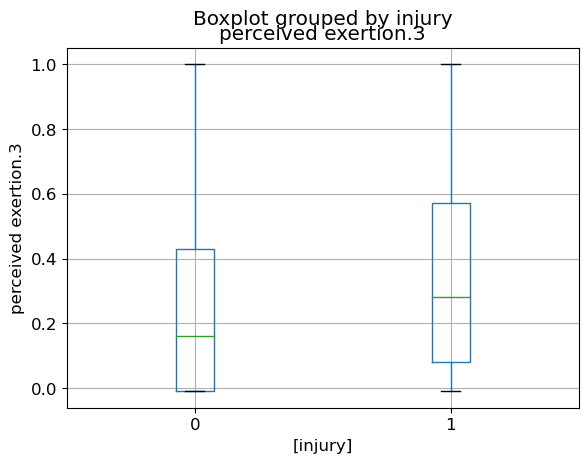

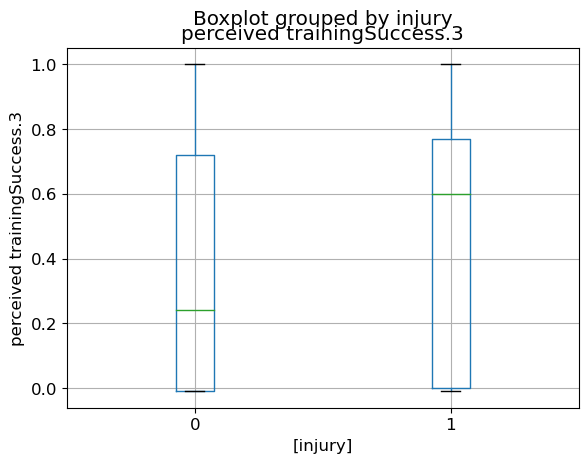

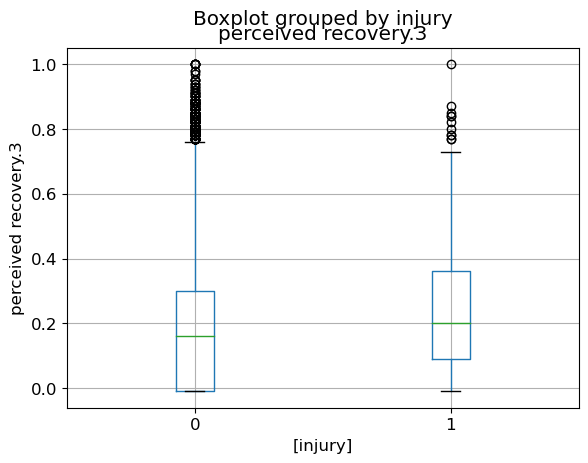

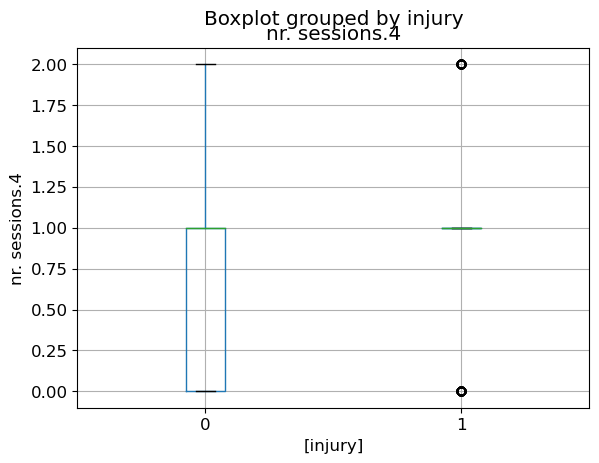

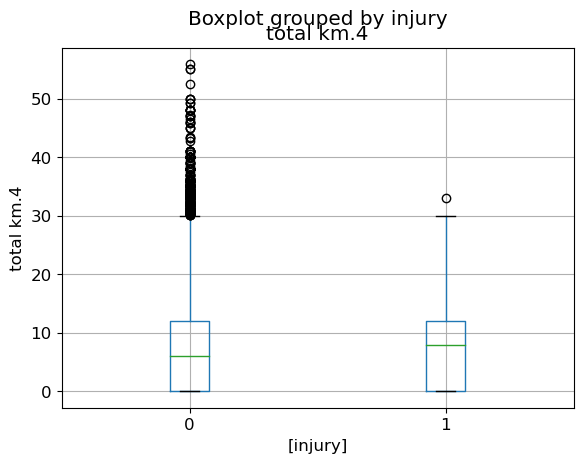

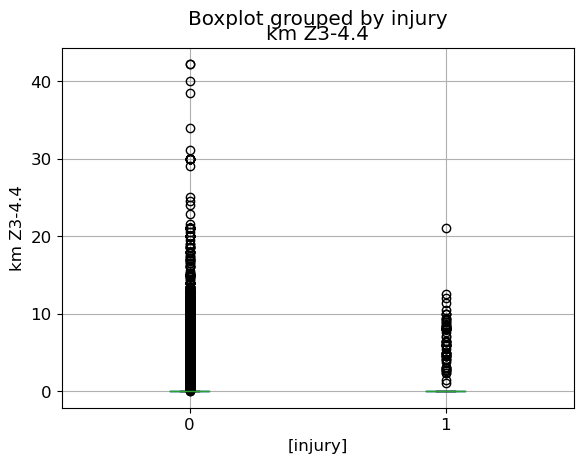

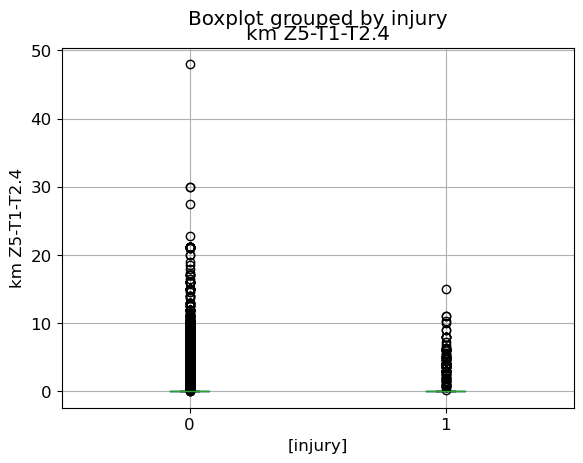

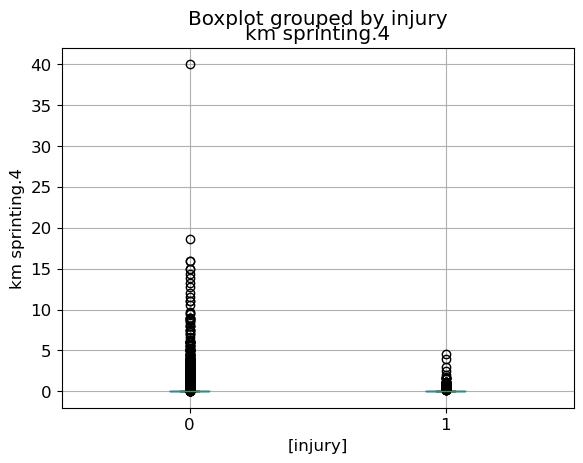

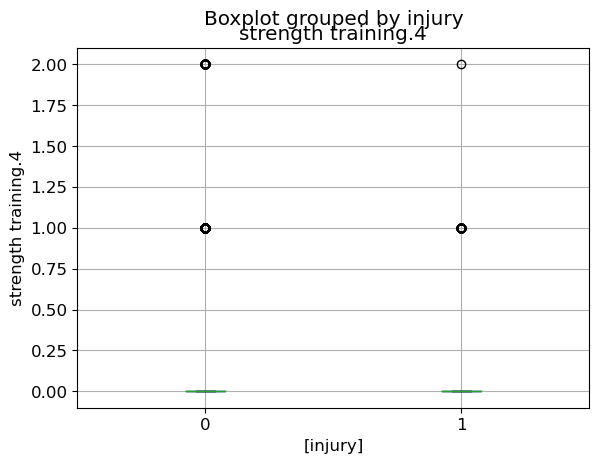

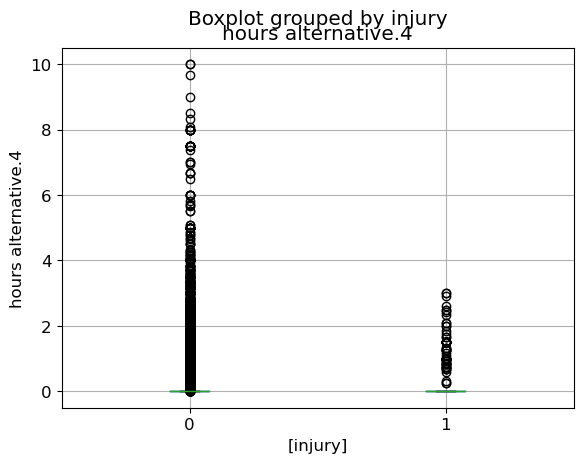

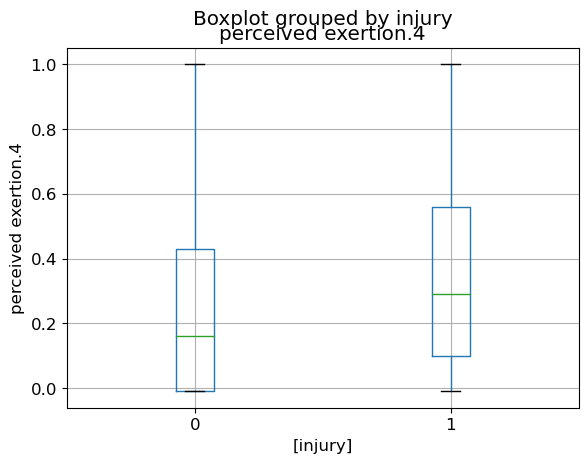

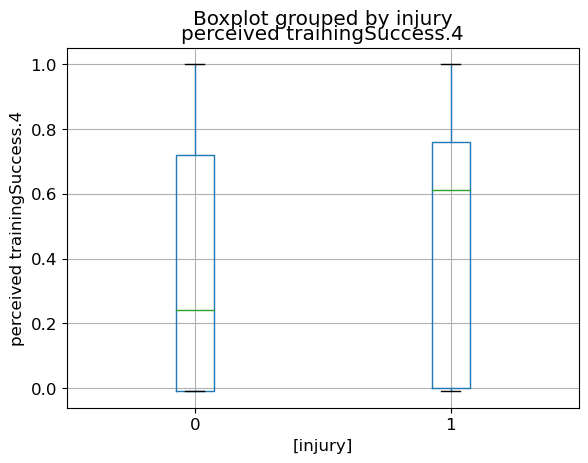

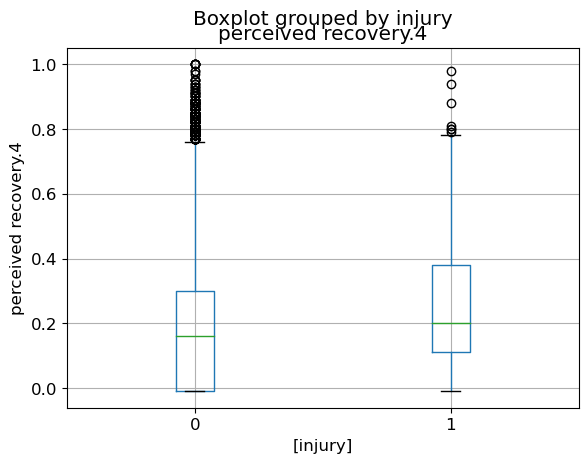

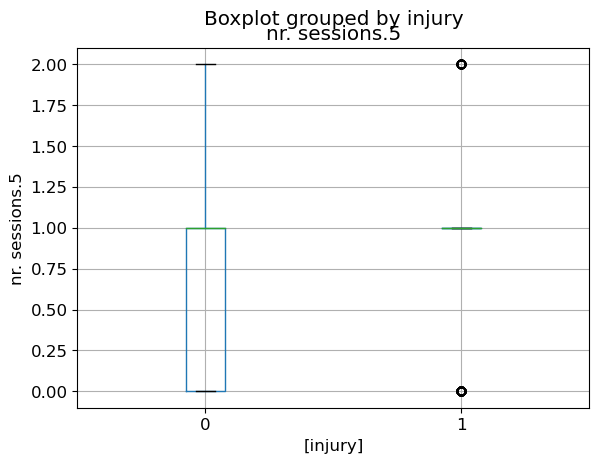

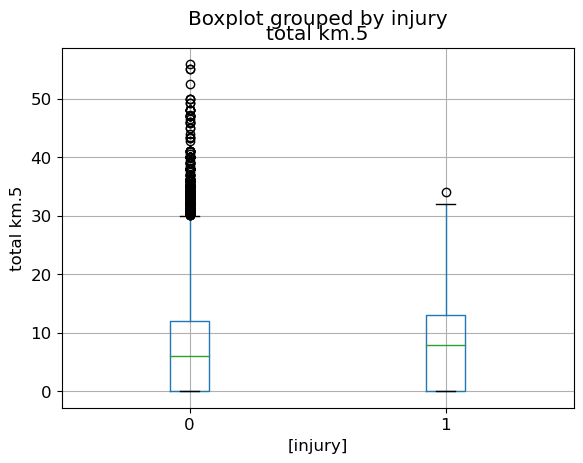

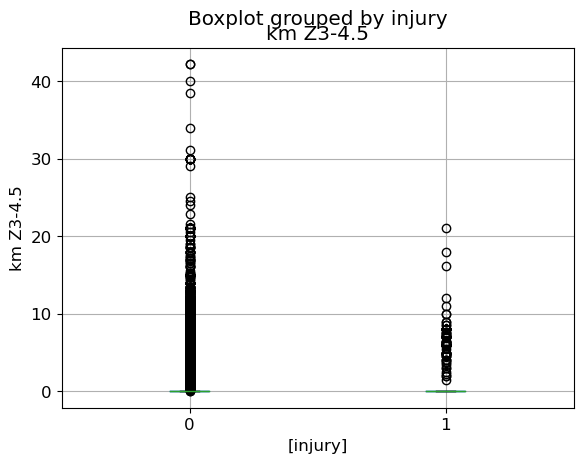

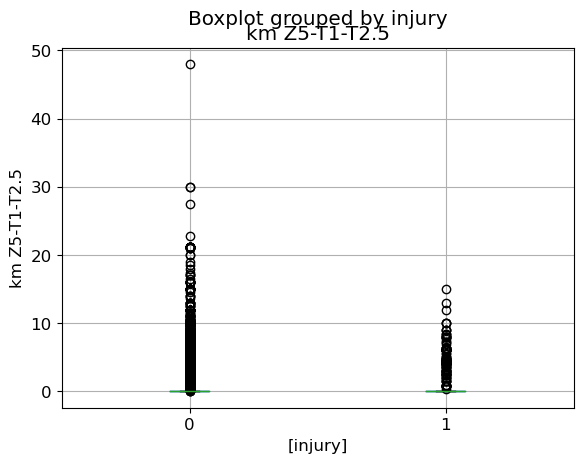

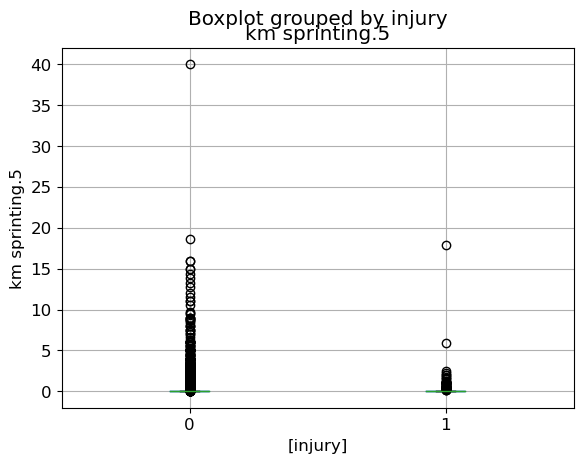

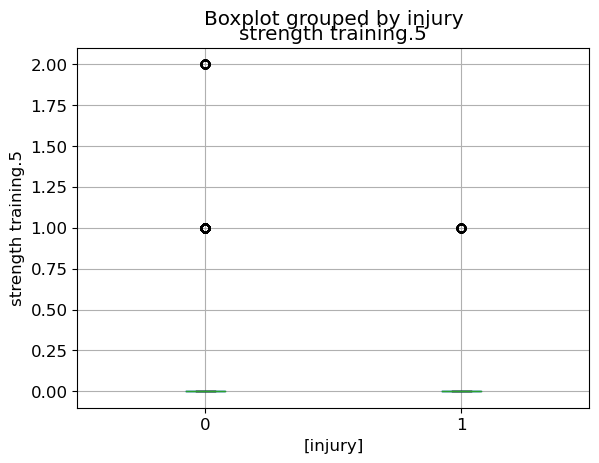

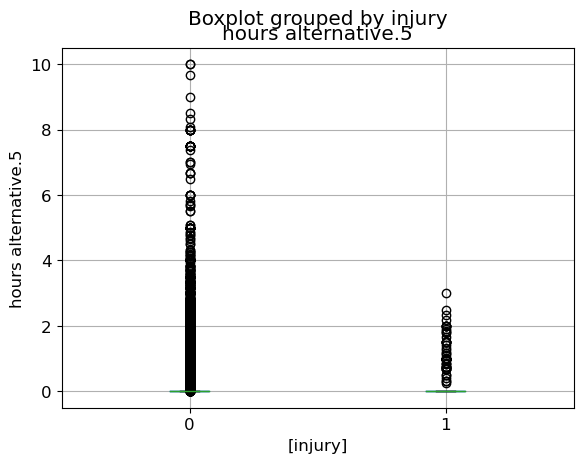

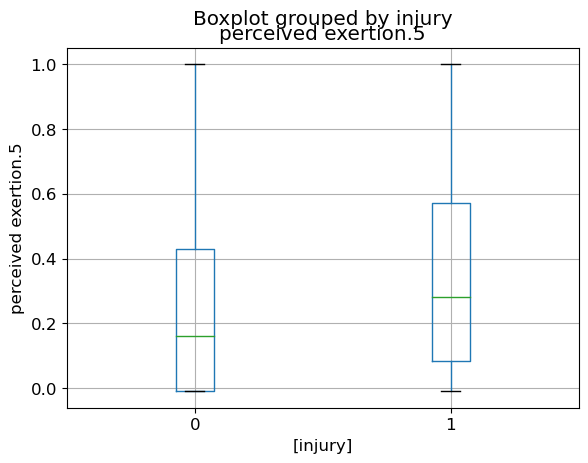

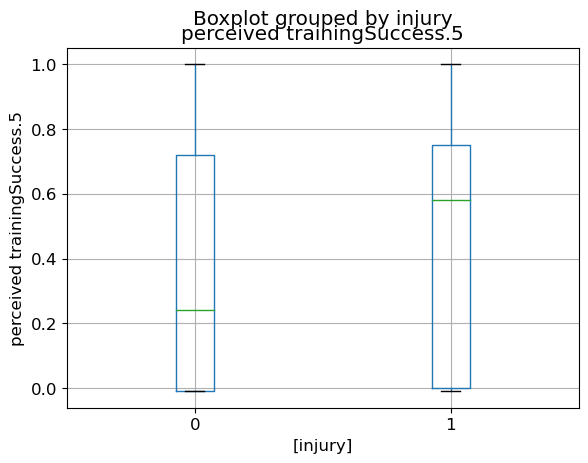

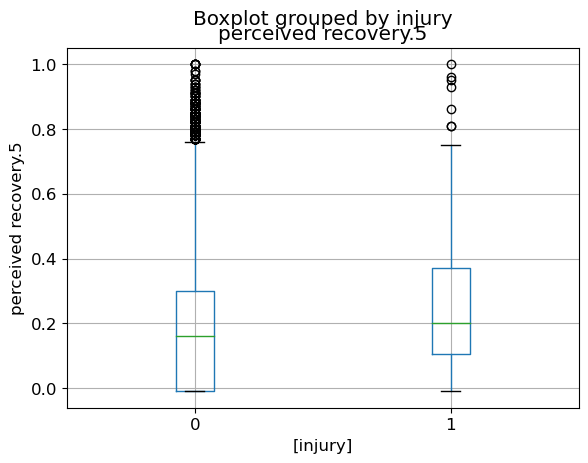

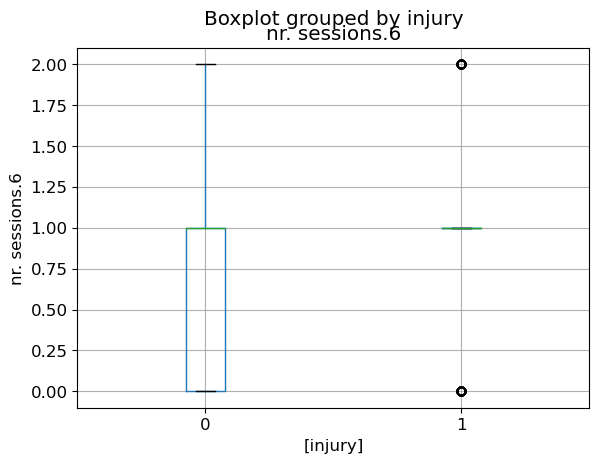

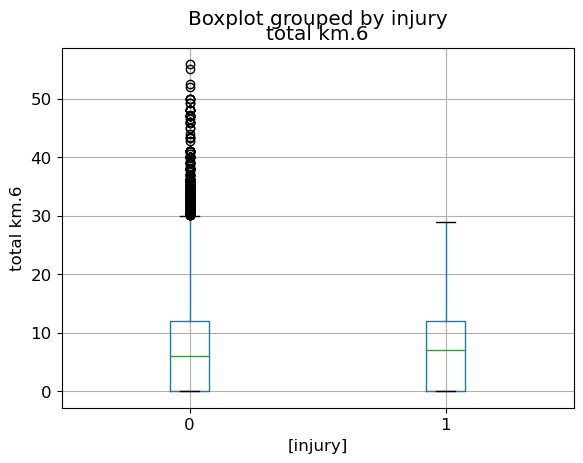

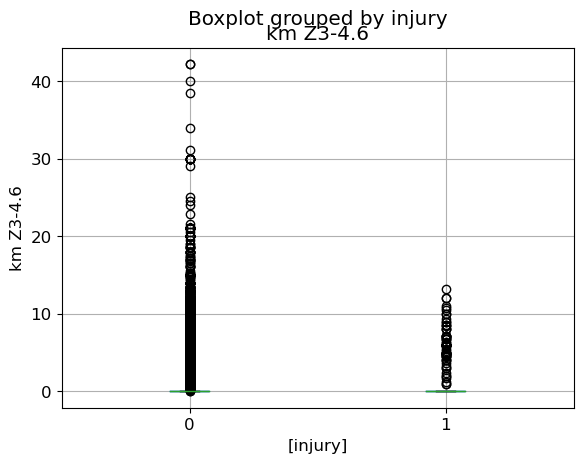

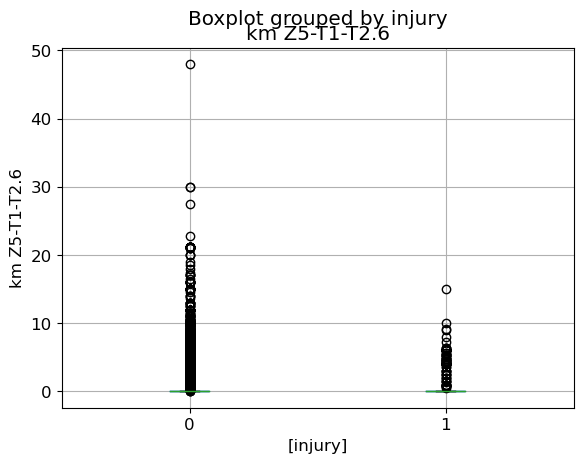

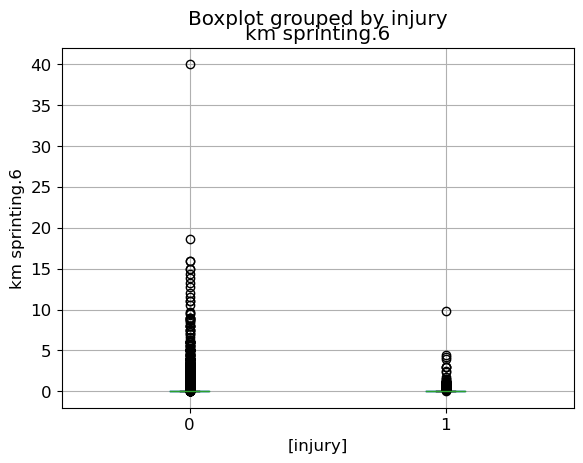

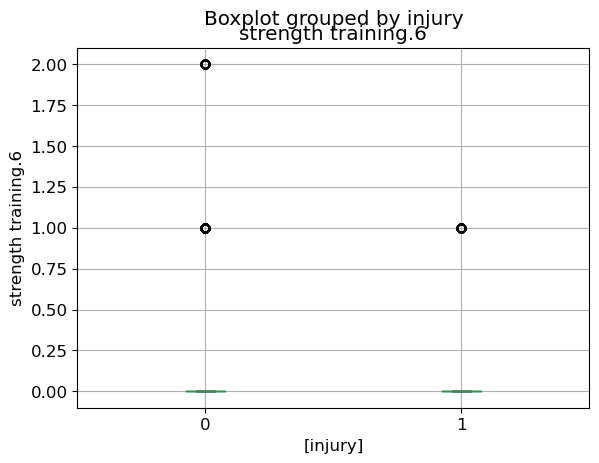

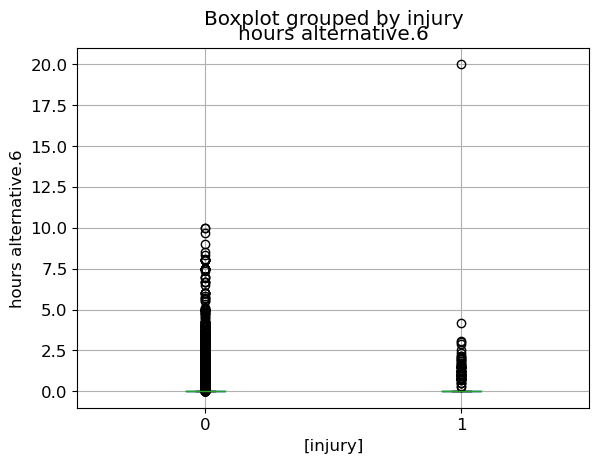

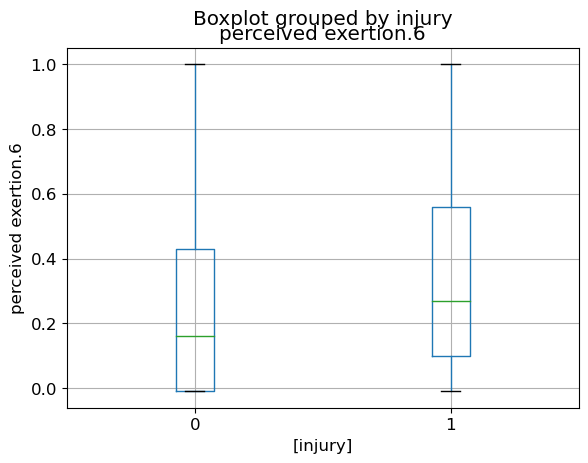

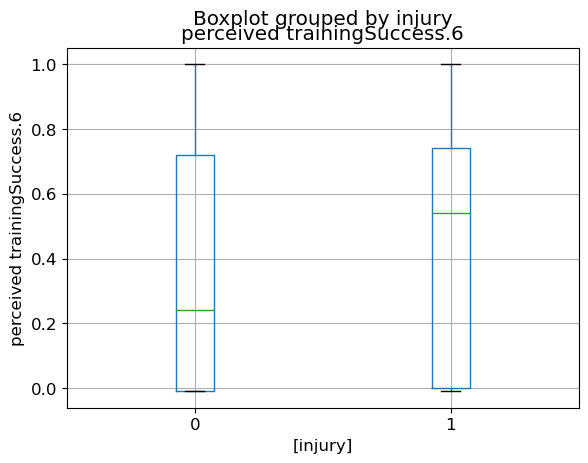

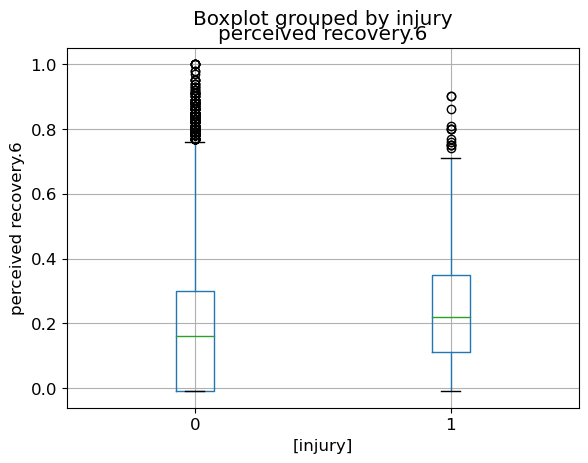

In [33]:
for ftr in cont_ftrs:
    df[[ftr,'injury']].boxplot(by = 'injury')
    plt.ylabel(ftr)
    plt.savefig('../figures/{}-injury.png'.format(ftr))
    plt.show()

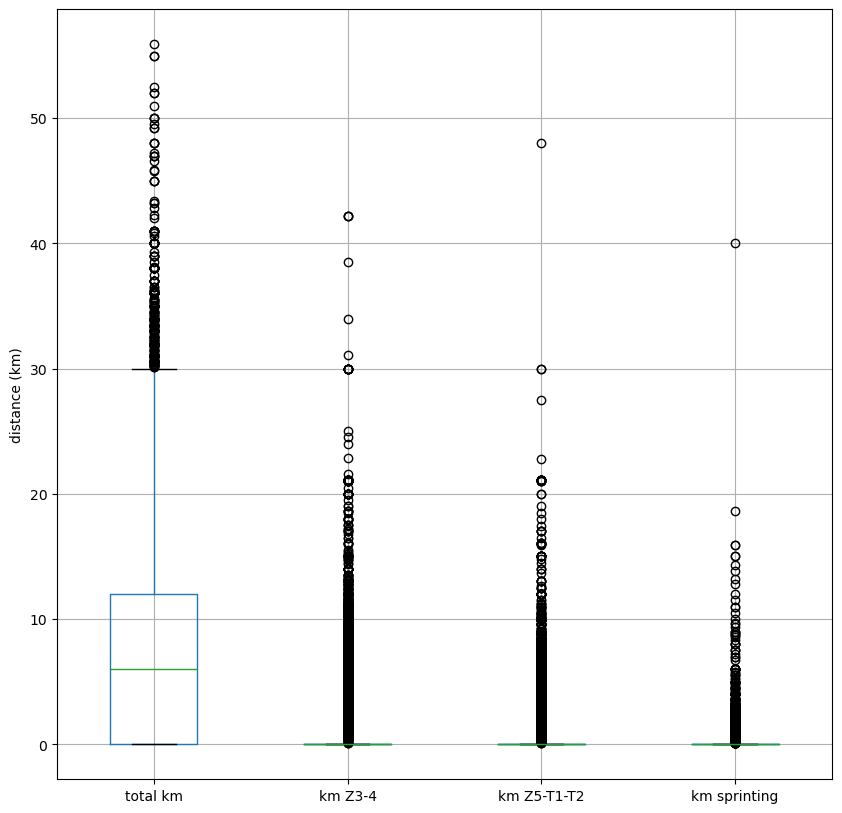

In [24]:
df.boxplot(column=['total km', 'km Z3-4', 'km Z5-T1-T2', 'km sprinting'], figsize = (10,10) )
plt.ylabel('distance (km)')
plt.show()

### Data Preprocessing ###

### Questions: ###


#### Athlete 32: the most active athlete ####

wanted to explore if I can run a model just for one athlete, but turns out there are two few data points containing injuries so I don't think this would work.

In [26]:
# using only athlete number 32

df_32 = df[df['Athlete ID'] == 32]


In [27]:
# less than one percent of the events have injuries! 
# i think this can cause a problem, need to figure out a way to deal with that
np.sum(df_32['injury'])/df_32.shape[0]

0.0072585147962032385

In [28]:
np.sum(df_32['injury'])

13

### Splitting Data ###

only considering the time series structure for now

still need to do more work to figure out how to deal with the issue that data from different athletes is not iid


In [37]:
df['Date'].describe()

count    42551.000000
mean      1233.663792
std        805.146649
min          0.000000
25%        469.000000
50%       1263.000000
75%       1918.000000
max       2673.000000
Name: Date, dtype: float64

In [41]:
# manually split the data into train val test with data sorted in order of Date
# function ensures that data points in train val test sets appear in chronological order, and that all the events from the same date will be in the same set

def basic_time_series_split(test_size, train_size, df):
    df = df.sort_values(by='Date')
    train_val_split = df.iloc[int(train_size * df.shape[0])][-1]
    test_split = df.iloc[int((1-test_size) * df.shape[0])][-1]
    

    df = df.sort_values(by = 'Date')

    df_train = df[df['Date'] < train_val_split]
    df_val = df[(df['Date'] < test_split) & (train_val_split <= df['Date']) ]
    df_test = df[test_split < df['Date']]

    X_test = df_test.drop(columns = ['injury'])
    y_test = df_test['injury']

    X_train = df_train.drop(columns = ['injury'])
    y_train = df_train['injury']
    
    X_val = df_val.drop(columns = ['injury'])
    y_val = df_val['injury']
    
    return X_test, y_test, X_train, y_train, X_val, y_val


In [42]:
X_test, y_test, X_train, y_train, X_val, y_val = basic_time_series_split(0.2,0.6,df)

In [43]:
np.sum(y_test)

150

In [44]:
np.sum(y_train)

300

In [45]:
np.sum(y_val)

132

### Preprocessing Data ###

all features except athlete ID are continuous
- experimented with minmax scaler and standard scaler
- decided to use standar scaler because although these features have a clear lower bound, they do not have a clear upper bound and have many outliers, does not make sense to contain everything between 0 and 1


athlete ID is categorical so I used onehotencoder to transform it



In [42]:
df.columns

Index(['nr. sessions', 'total km', 'km Z3-4', 'km Z5-T1-T2', 'km sprinting',
       'strength training', 'hours alternative', 'perceived exertion',
       'perceived trainingSuccess', 'perceived recovery', 'nr. sessions.1',
       'total km.1', 'km Z3-4.1', 'km Z5-T1-T2.1', 'km sprinting.1',
       'strength training.1', 'hours alternative.1', 'perceived exertion.1',
       'perceived trainingSuccess.1', 'perceived recovery.1', 'nr. sessions.2',
       'total km.2', 'km Z3-4.2', 'km Z5-T1-T2.2', 'km sprinting.2',
       'strength training.2', 'hours alternative.2', 'perceived exertion.2',
       'perceived trainingSuccess.2', 'perceived recovery.2', 'nr. sessions.3',
       'total km.3', 'km Z3-4.3', 'km Z5-T1-T2.3', 'km sprinting.3',
       'strength training.3', 'hours alternative.3', 'perceived exertion.3',
       'perceived trainingSuccess.3', 'perceived recovery.3', 'nr. sessions.4',
       'total km.4', 'km Z3-4.4', 'km Z5-T1-T2.4', 'km sprinting.4',
       'strength training.4',

In [55]:
# number of session in each day: either 0,1 or 2
np.unique(df.loc[:,df.columns.str.startswith('nr. sessions')].values)

array([0., 1., 2.])

In [56]:
np.unique(df.loc[:,df.columns.str.startswith('strength training')].values)

array([0., 1., 2.])

In [53]:
# make lists for different features to transform


other_ftrs = ['injury', 'Date']

# will leave this feature as is because it is already between 0 and 1
perc_ftrs = [col for col in df if col.startswith('perceiv')]

# use minmax for values that have clear bounds
mm_ftrs = [col for col in df if col.startswith('nr.') or col.startswith('strength')]

# use standard scaler for other continuous variables
std_ftrs = [col for col in df if ((col not in other_ftrs) and (col not in perc_ftrs) and (col not in mm_ftrs) and (col not in cat_ftrs))]

# use onehotencoder for the categorical variable
cat_ftrs = ['Athlete ID']

#### Transforming data ####

In [59]:
mm_scaler = MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train[mm_ftrs])
X_val_mm = mm_scaler.transform(X_val[mm_ftrs])
X_test_mm = mm_scaler.transform(X_test[mm_ftrs])

In [60]:
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train[std_ftrs])
X_val_std = std_scaler.transform(X_val[std_ftrs])
X_test_std = std_scaler.transform(X_test[std_ftrs])

In [61]:
ohe = OneHotEncoder(sparse = False, handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(X_train[cat_ftrs])
X_val_ohe = ohe.transform(X_val[cat_ftrs])
X_test_ohe = ohe.transform(X_test[cat_ftrs])

In [50]:
# only 64 athletes were present in the training set
ohe.categories_

[array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])]

In [66]:
X_train_ohe.shape

(25528, 63)

In [65]:
X_train_mm.shape

(25528, 14)

In [64]:
X_train_std.shape

(25528, 35)